In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import autorootcwd
import torch
import os
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import DataLoader
from sklearn.metrics import confusion_matrix

from src.utils import id_to_chord_map, get_torch_device, collate_fn, get_annotation_metadata, get_chord_quality, get_chord_root, get_split_filenames
from src.models.crnn import CRNN
from src.data.dataset import FullChordDataset

## Basics

In [3]:
DIR = './results'
experiment_name = 'cr2/cr2_off'

def get_model(exp_path):
    device = get_torch_device()
    state_dict = torch.load(f'{DIR}/{exp_path}/best_model.pth', map_location=device, weights_only=True)
    model = CRNN()
    model.load_state_dict(state_dict)
    model.eval()
    return model

model = get_model(experiment_name)

/Users/pierrelardet/.pyenv/versions/UG4Diss/lib/python3.8/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


### Run the Model

In [4]:
_, val_filenames, _ = get_split_filenames()

dataset = FullChordDataset(filenames=val_filenames, dev_mode=True)

dataset[0][1].shape

torch.Size([0])

In [13]:
def get_predictions(model, dataset):
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Use no_grad to speed up inference
        for i in tqdm(range(len(dataset))):
            cqt, _, label = dataset[i]
            pred = model(cqt.unsqueeze(0))
            preds = torch.argmax(pred, dim=2)
            all_preds.append(preds[0])  # Keep as tensors
            all_labels.append(label)    # Keep as tensors

    # Concatenate all predictions and labels at the end
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    return all_preds, all_labels

all_preds, all_labels = get_predictions(model, dataset)

100%|██████████| 241/241 [00:38<00:00,  6.27it/s]


### Overall Accuracy

In [9]:
# Overall accuracy
from sklearn.metrics import accuracy_score
accuracy_score(all_labels, all_preds)

0.5819452001588604

## Confusion Matrices

### Qualities

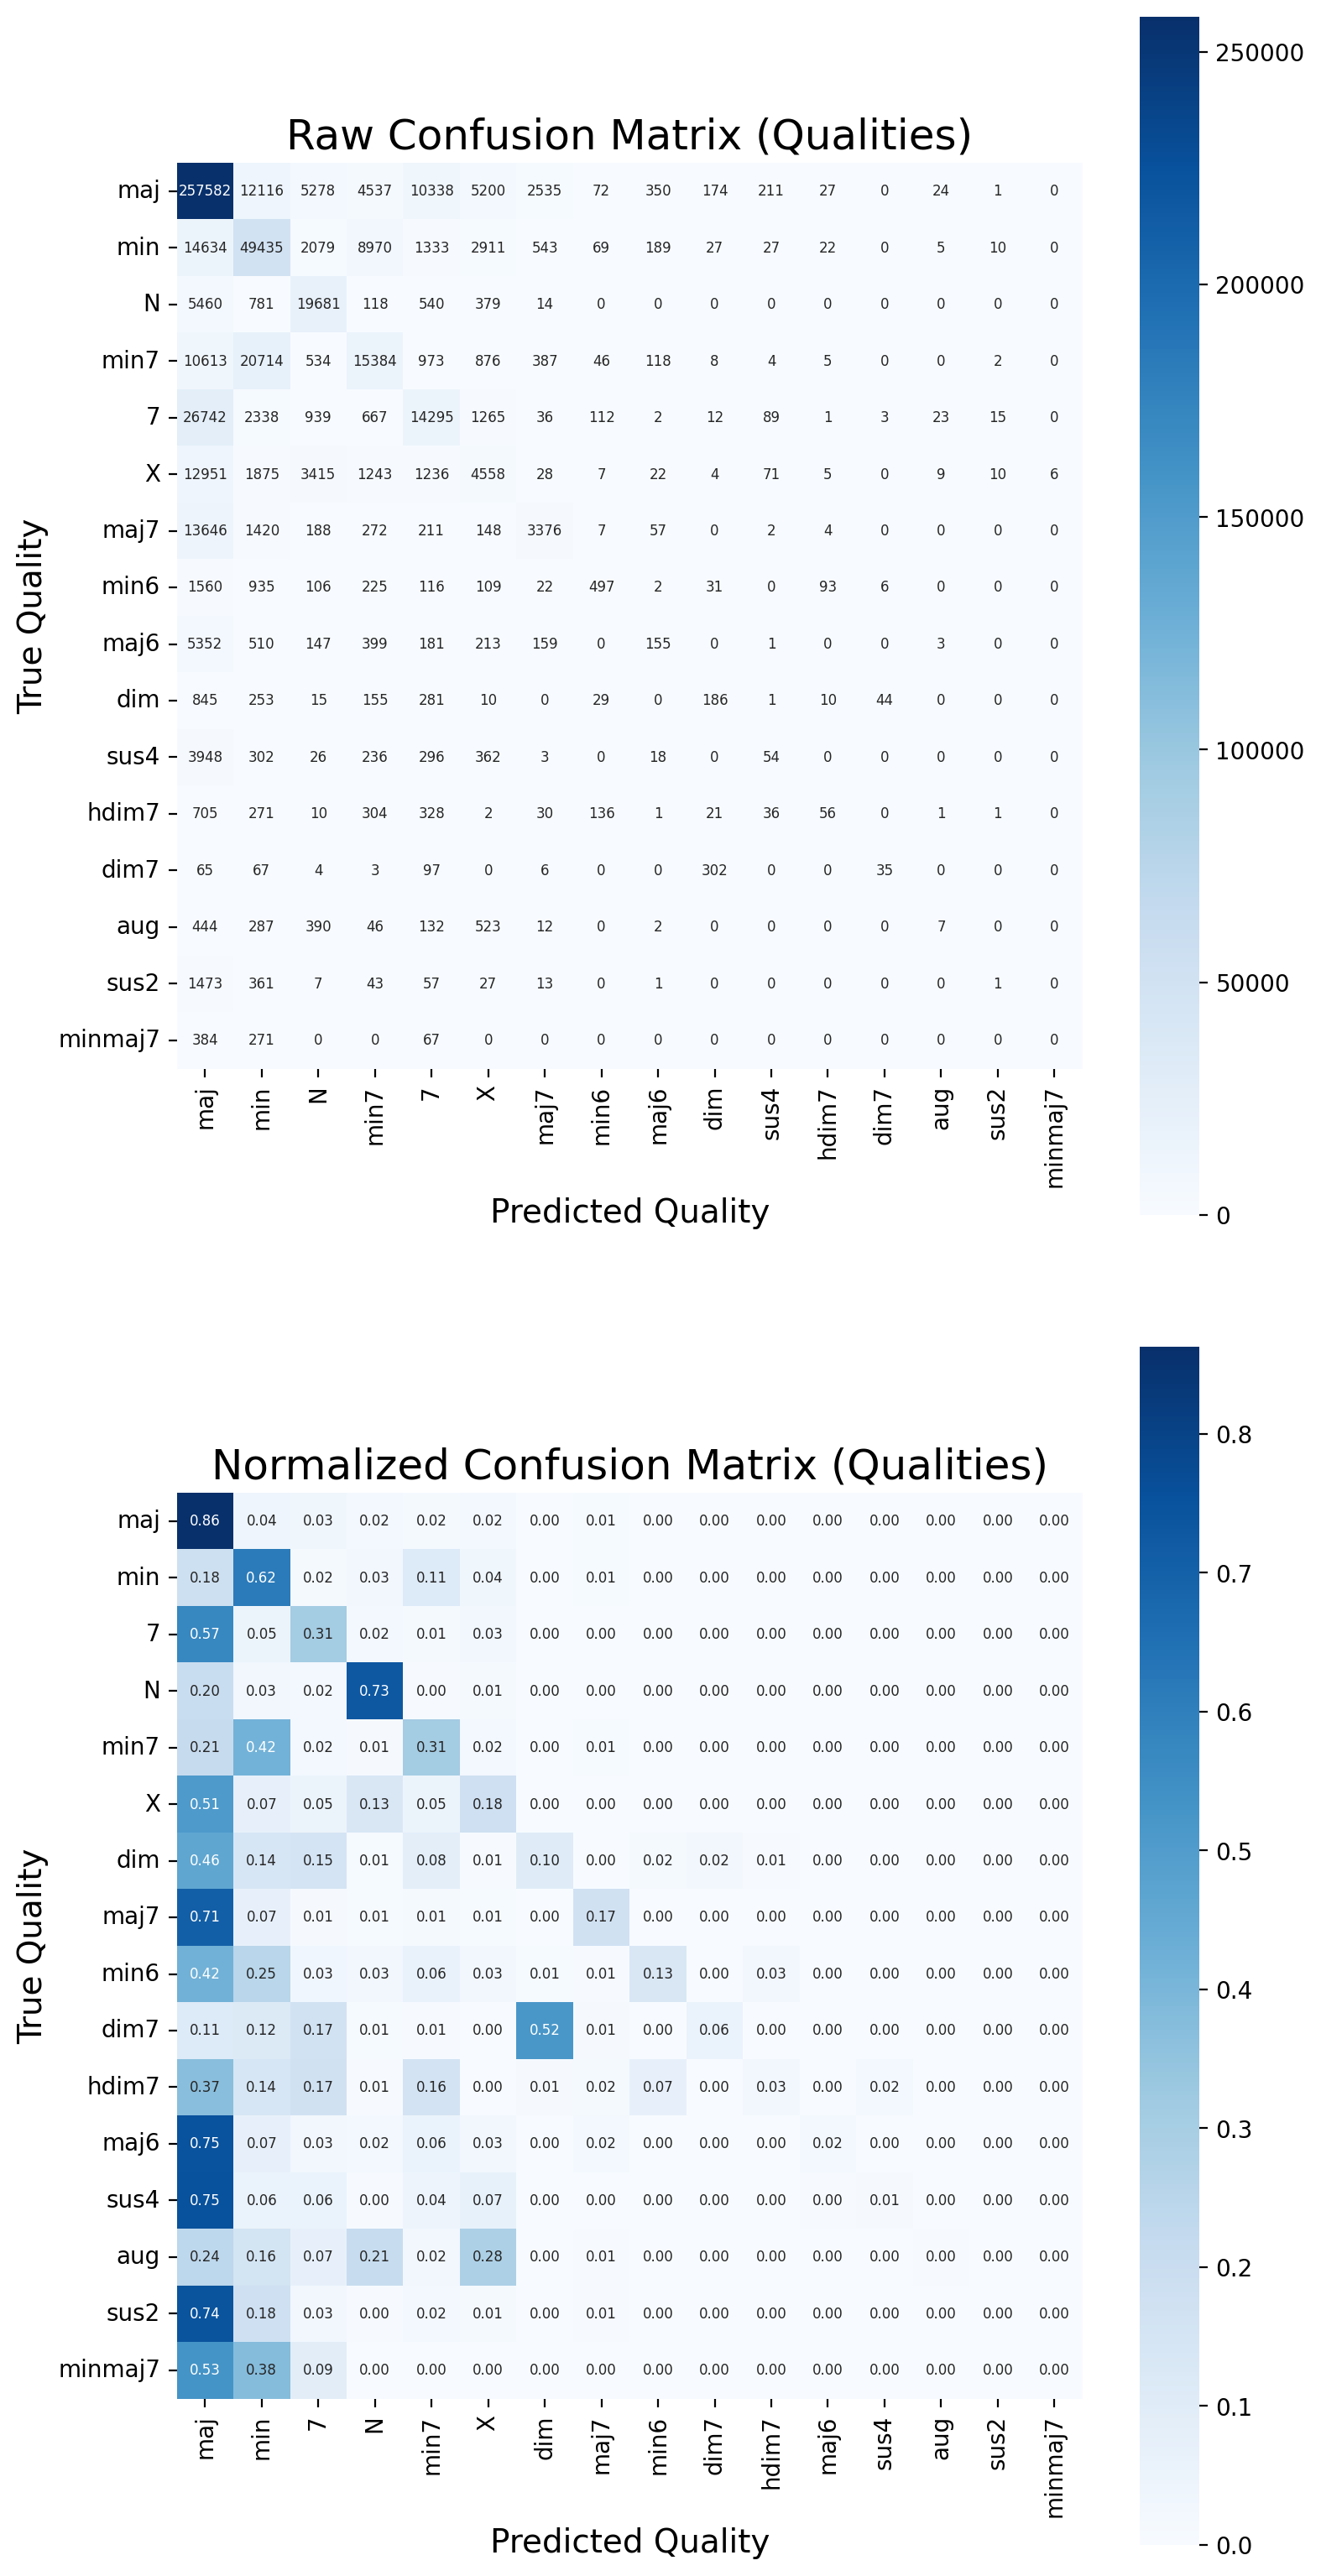

In [10]:
# Map chord IDs to chord qualities
all_labels_quality = [get_chord_quality(id.item()) for id in all_labels]
all_preds_quality = [get_chord_quality(id.item()) for id in all_preds]

# Get unique qualities and map them to indices
unique_qualities = sorted(set(all_labels_quality + all_preds_quality))
quality_to_id = {quality: i for i, quality in enumerate(unique_qualities)}
id_to_quality = {i: quality for i, quality in enumerate(unique_qualities)}

# Convert qualities to indices for confusion matrix computation
labels_quality_idx = [quality_to_id[quality] for quality in all_labels_quality]
preds_quality_idx = [quality_to_id[quality] for quality in all_preds_quality]

# Compute confusion matrix and normalized confusion matrix
cm_quality = confusion_matrix(labels_quality_idx, preds_quality_idx, labels=range(len(unique_qualities)))
cm_quality_normalized = cm_quality.astype('float') / cm_quality.sum(axis=1, keepdims=True)

# Reorder both confusion matrices by commonality of chords
order_quality = np.argsort(np.sum(cm_quality, axis=0))[::-1]
order_quality_normalized = np.argsort(np.sum(cm_quality_normalized, axis=0))[::-1]

# Reorder the confusion matrices
cm_quality_reordered = cm_quality[order_quality][:, order_quality]
cm_quality_normalized_reordered = cm_quality_normalized[order_quality_normalized][:, order_quality_normalized]

# Map reordered indices back to chord qualities
quality_labels_reordered = [id_to_quality[id] for id in order_quality]
quality_labels_normalized_reordered = [id_to_quality[id] for id in order_quality_normalized]

# Plot the confusion matrices
fig, axes = plt.subplots(2, 1, figsize=(8, 16))

# Raw confusion matrix (qualities)
sns.heatmap(cm_quality_reordered, annot=True, fmt='d', cmap='Blues', 
            xticklabels=quality_labels_reordered, yticklabels=quality_labels_reordered, 
            ax=axes[0], cbar=True, annot_kws={"fontsize": 6}, square=True)
axes[0].set_title("Raw Confusion Matrix (Qualities)", fontsize=18)
axes[0].set_xlabel('Predicted Quality', fontsize=14)
axes[0].set_ylabel('True Quality', fontsize=14)

# Normalized confusion matrix (qualities)
sns.heatmap(cm_quality_normalized_reordered, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=quality_labels_normalized_reordered, yticklabels=quality_labels_normalized_reordered, 
            ax=axes[1], cbar=True, annot_kws={"fontsize": 6}, square=True)
axes[1].set_title("Normalized Confusion Matrix (Qualities)", fontsize=18)
axes[1].set_xlabel('Predicted Quality', fontsize=14)
axes[1].set_ylabel('True Quality', fontsize=14)

plt.tight_layout()
plt.show()

#### VS weighted Loss

In [11]:
weighted_exp = 'weight_alpha_search/alpha_0.3'
model_weighted = get_model(weighted_exp)
all_preds_weighted, all_labels_weighted = get_predictions(model_weighted, dataset)

100%|██████████| 241/241 [00:44<00:00,  5.40it/s]


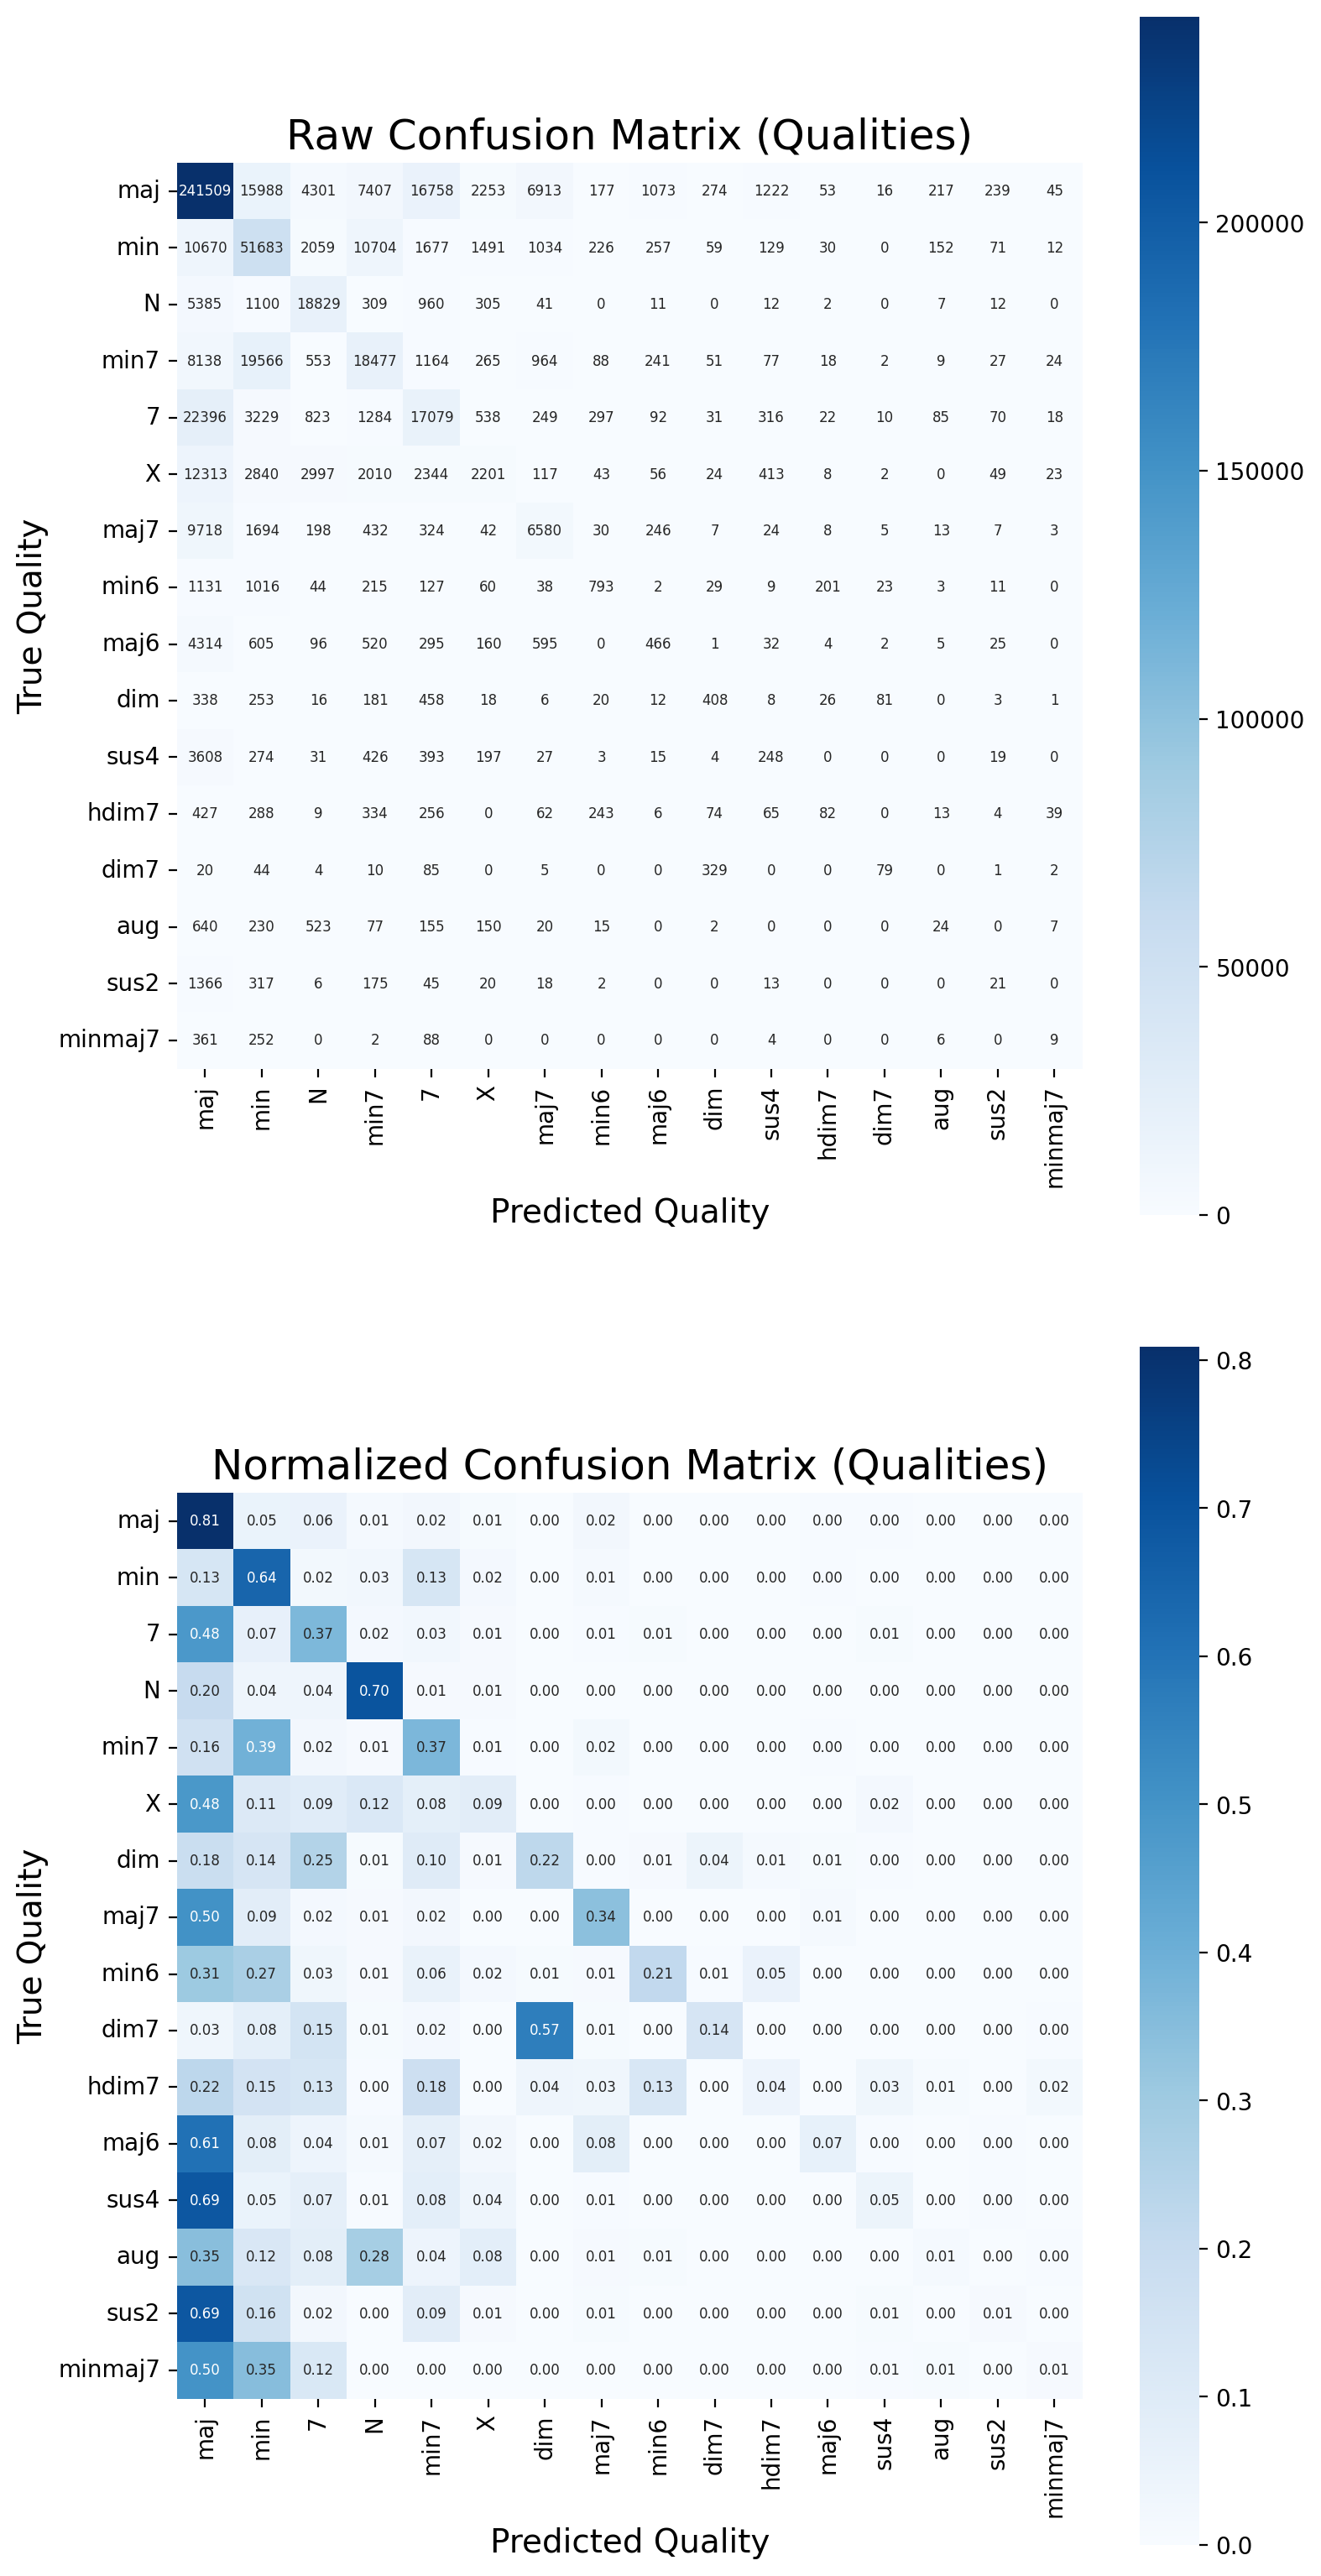

In [12]:
# Map chord IDs to chord qualities
all_labels_quality = [get_chord_quality(id.item()) for id in all_labels_weighted]
all_preds_quality = [get_chord_quality(id.item()) for id in all_preds_weighted]

# Get unique qualities and map them to indices
unique_qualities = sorted(set(all_labels_quality + all_preds_quality))
quality_to_id = {quality: i for i, quality in enumerate(unique_qualities)}
id_to_quality = {i: quality for i, quality in enumerate(unique_qualities)}

# Convert qualities to indices for confusion matrix computation
labels_quality_idx = [quality_to_id[quality] for quality in all_labels_quality]
preds_quality_idx = [quality_to_id[quality] for quality in all_preds_quality]

# Compute confusion matrix and normalized confusion matrix
cm_quality = confusion_matrix(labels_quality_idx, preds_quality_idx, labels=range(len(unique_qualities)))
cm_quality_normalized = cm_quality.astype('float') / cm_quality.sum(axis=1, keepdims=True)

# Reorder the confusion matrices
cm_quality_reordered_weighted = cm_quality[order_quality][:, order_quality]
cm_quality_normalized_reordered_weighted = cm_quality_normalized[order_quality_normalized][:, order_quality_normalized]

# Map reordered indices back to chord qualities
quality_labels_reordered_weighted = [id_to_quality[id] for id in order_quality]
quality_labels_normalized_reordered_weighted = [id_to_quality[id] for id in order_quality_normalized]

# Plot the confusion matrices
fig, axes = plt.subplots(2, 1, figsize=(8,16))

# Raw confusion matrix (qualities)
sns.heatmap(cm_quality_reordered_weighted, annot=True, fmt='d', cmap='Blues', 
            xticklabels=quality_labels_reordered_weighted, yticklabels=quality_labels_reordered_weighted, 
            ax=axes[0], cbar=True, annot_kws={"fontsize": 6}, square=True)
axes[0].set_title("Raw Confusion Matrix (Qualities)", fontsize=18)
axes[0].set_xlabel('Predicted Quality', fontsize=14)
axes[0].set_ylabel('True Quality', fontsize=14)

# Normalized confusion matrix (qualities)
sns.heatmap(cm_quality_normalized_reordered_weighted, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=quality_labels_normalized_reordered_weighted, yticklabels=quality_labels_normalized_reordered_weighted, 
            ax=axes[1], cbar=True, annot_kws={"fontsize": 6}, square=True)
axes[1].set_title("Normalized Confusion Matrix (Qualities)", fontsize=18)
axes[1].set_xlabel('Predicted Quality', fontsize=14)
axes[1].set_ylabel('True Quality', fontsize=14)

plt.tight_layout()
plt.show()

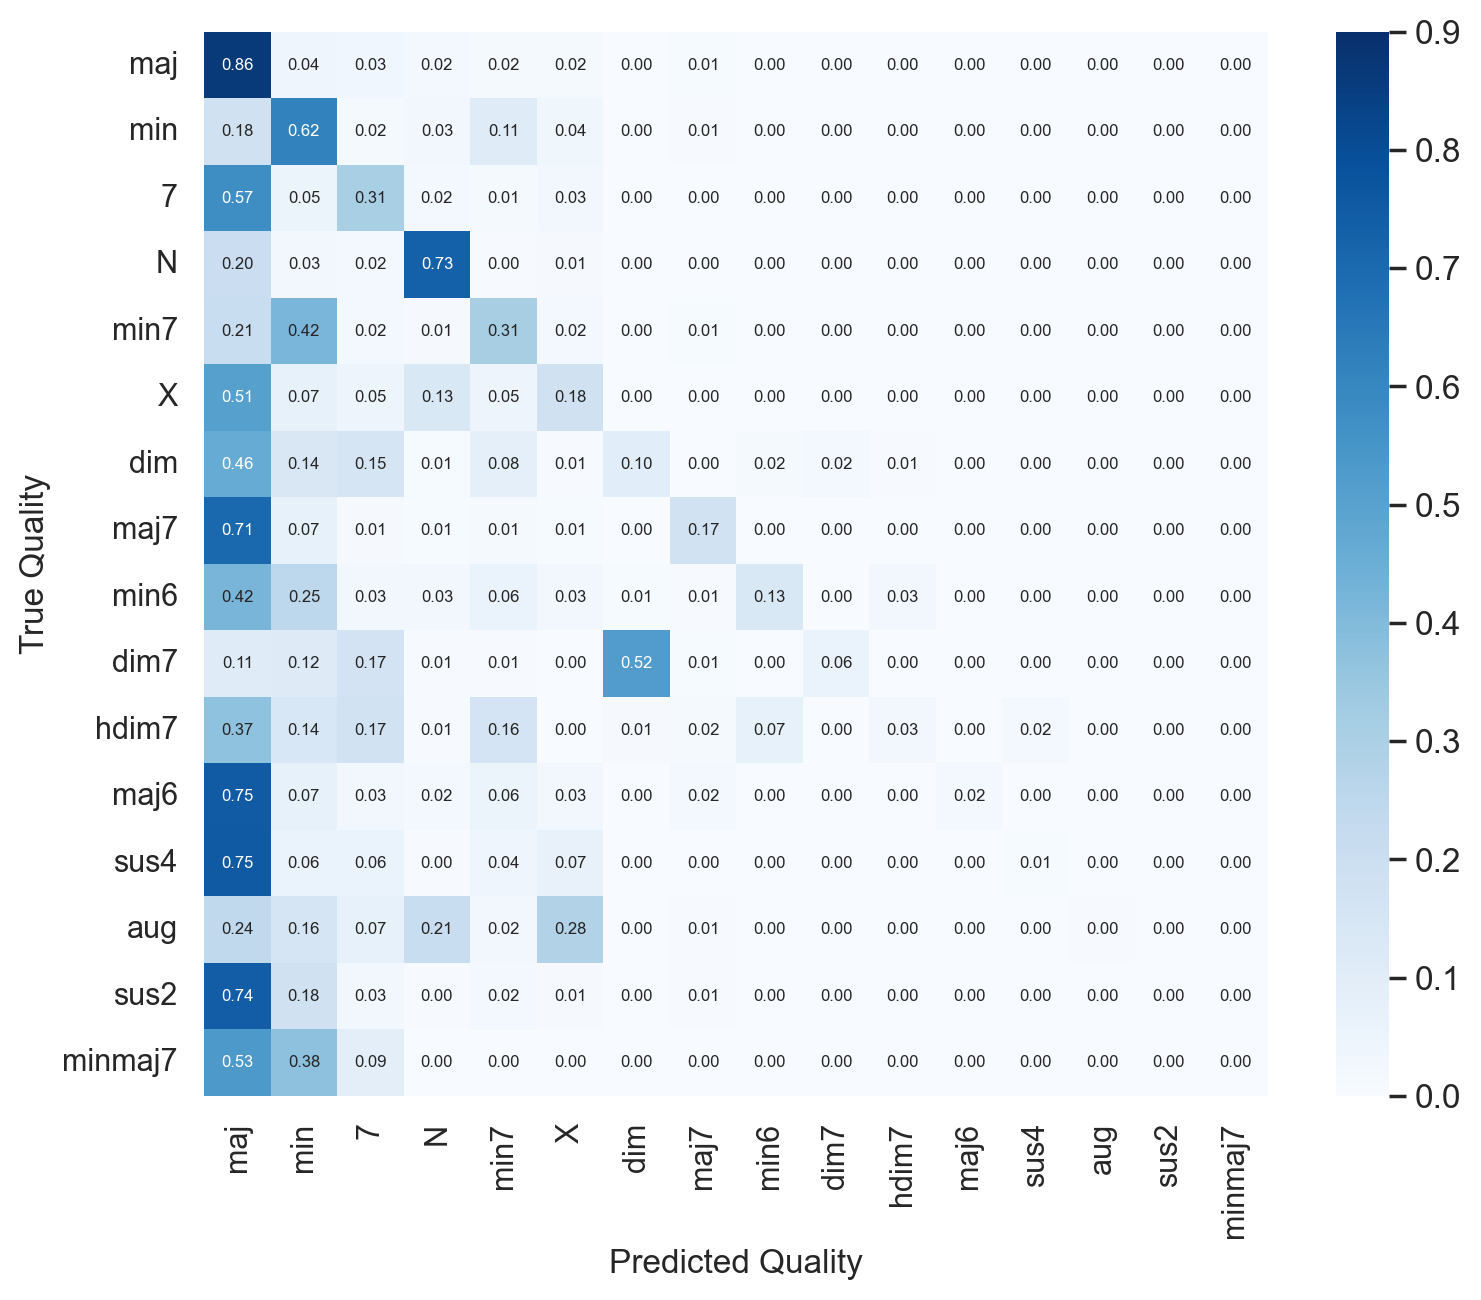

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axes = plt.subplots(figsize=(8, 7))

# Plot heatmaps without colorbars
hm1 = sns.heatmap(cm_quality_normalized_reordered, annot=True, fmt='.2f', cmap='Blues', 
                  xticklabels=quality_labels_normalized_reordered, 
                  yticklabels=quality_labels_normalized_reordered, 
                  ax=axes, cbar=False, annot_kws={"fontsize": 6}, square=True,
                  vmin=0, vmax=0.9)
# axes[0].set_title("Confusion Matrix over Chord Qualities", fontsize=18, pad=10)
axes.set_xlabel('Predicted Quality', fontsize=12)
axes.set_ylabel('True Quality', fontsize=12)

# hm2 = sns.heatmap(cm_quality_normalized_reordered_weighted, annot=True, fmt='.2f', cmap='Blues', 
#                   xticklabels=quality_labels_normalized_reordered_weighted, 
#                   yticklabels=quality_labels_normalized_reordered_weighted, 
#                   ax=axes[1], cbar=False, annot_kws={"fontsize": 6}, square=True,
#                   vmin=0, vmax=0.9)
# axes[1].set_title("Weighted Loss Confusion Matrix over Chord Qualities", fontsize=18, pad=10)
# axes[1].set_title("", fontsize=18, pad=10)
# axes[1].set_xlabel('Predicted Quality', fontsize=12)
# axes[1].set_ylabel('True Quality', fontsize=14)

# Create a shared colorbar at the top
# cbar_ax = fig.add_axes([0.88, 0.25, 0.02, 0.5]) # [left, bottom, width, height]
cbar = fig.colorbar(hm1.collections[0])

# Adjust color bar limits explicitly to be 0, max of both heatmaps
cbar.set_ticks(np.linspace(0, 0.9, 10))
cbar.set_ticklabels(np.round(np.linspace(0, 0.9, 10), 1))
cbar.ax.tick_params(labelsize=12)
# Remove color bar border
cbar.outline.set_visible(False)

# Make the color bar wider
# cbar_ax.set_aspect(1.0)

# Adjust layout to provide more space
plt.tight_layout(rect=[0, 0.08, 1, 1])  # Leave room for the color bar
plt.savefig('./thesis/figures/confusion_matrix_qualities.png', dpi=200, bbox_inches='tight')
plt.show()

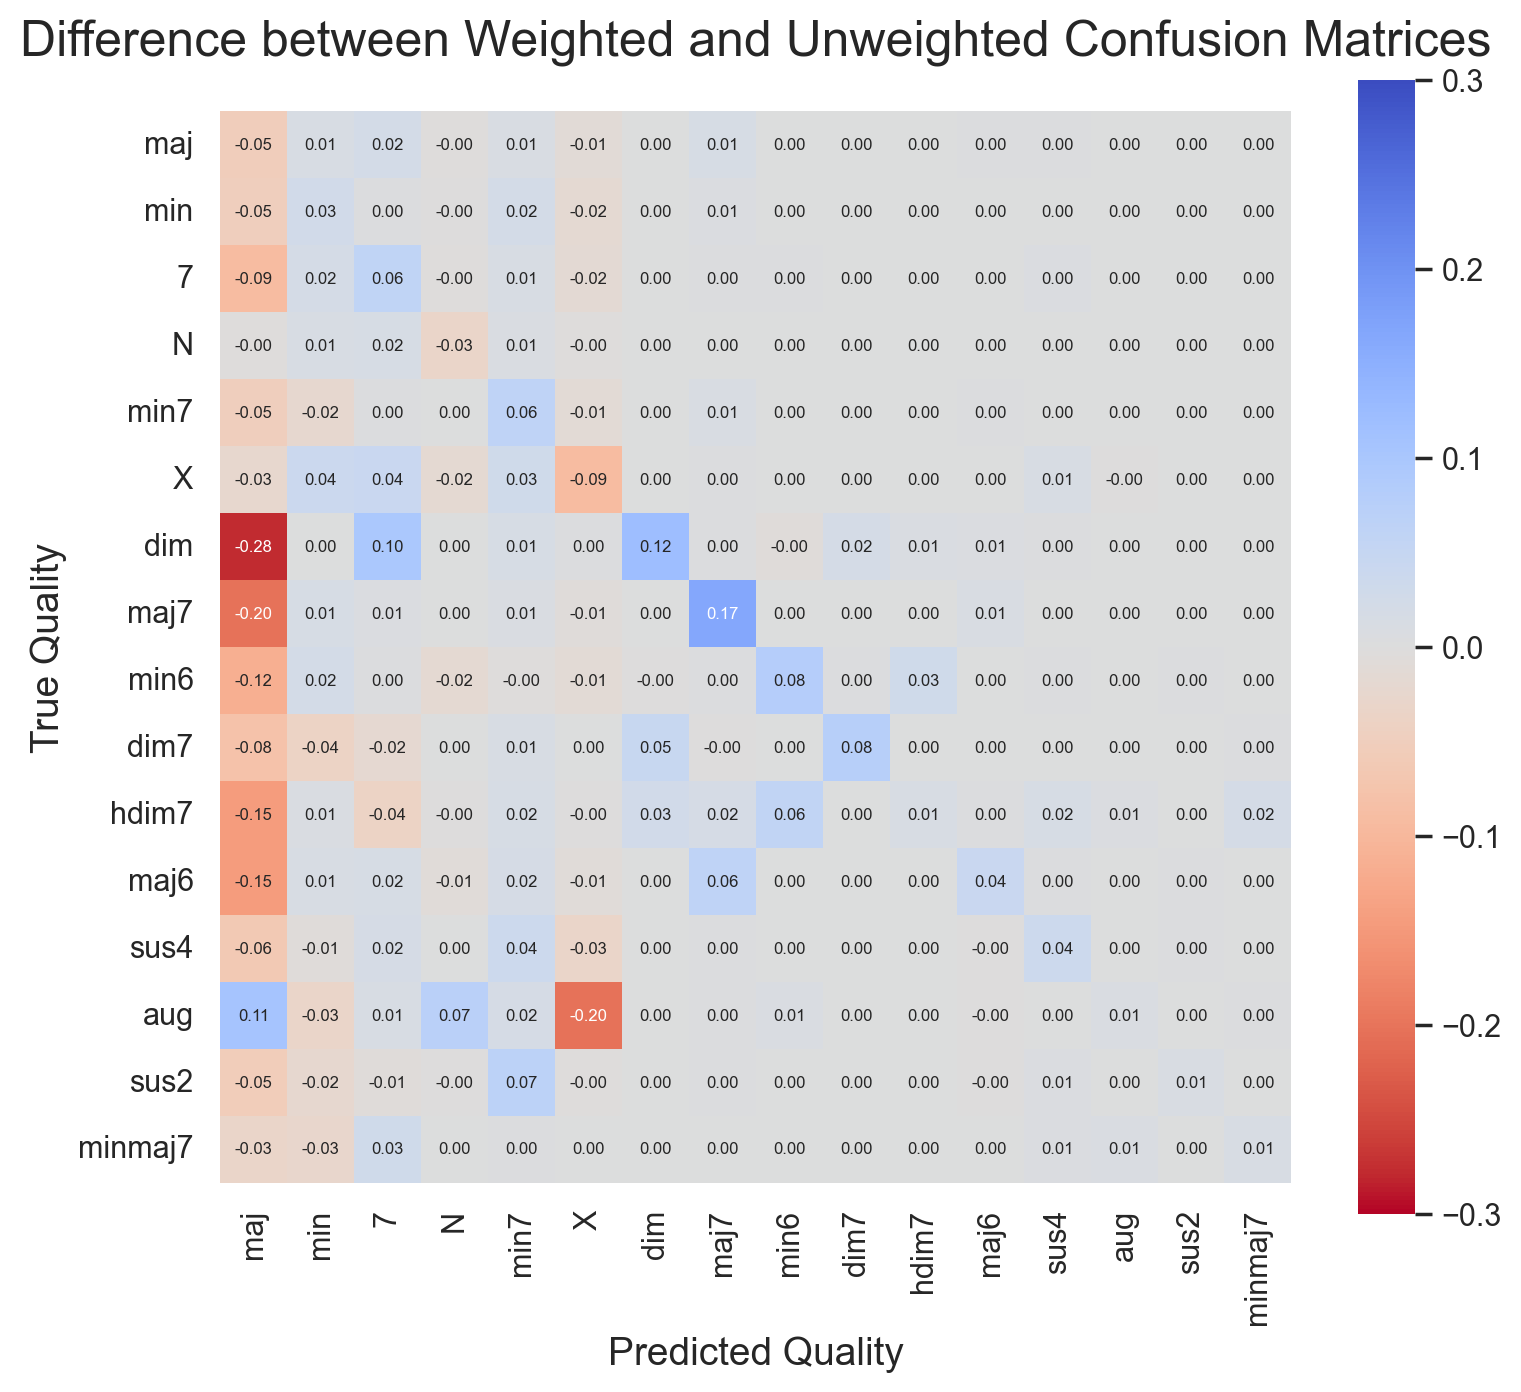

In [85]:
# Plot of difference between weighted and not weighted
fig, axes = plt.subplots(figsize=(8, 7))
# Compute the difference between the two normalized confusion matrices
diff_matrix = cm_quality_normalized_reordered_weighted - cm_quality_normalized_reordered
# Plot the difference matrix
sns.heatmap(diff_matrix, annot=True, fmt='.2f', cmap='coolwarm_r', 
            xticklabels=quality_labels_normalized_reordered_weighted, 
            yticklabels=quality_labels_normalized_reordered, 
            ax=axes, cbar=True, annot_kws={"fontsize": 6}, square=True,
            vmin=-0.3, vmax=0.3)
axes.set_title("Difference between Weighted and Unweighted Confusion Matrices", fontsize=18, pad=20)
axes.set_xlabel('Predicted Quality', fontsize=14)
axes.set_ylabel('True Quality', fontsize=14)
plt.tight_layout()
plt.savefig('./thesis/figures/confusion_matrix_difference.png', dpi=200, bbox_inches='tight')
plt.show()

In [17]:
# How many more times is X predicted than in the weighted model?
idx = quality_labels_reordered.index('X')
sums = np.sum(cm_quality_reordered, axis=0)
sums_weighted = np.sum(cm_quality_reordered_weighted, axis=0)
sums[idx] / sums_weighted[idx]

2.153636363636364

### Roots

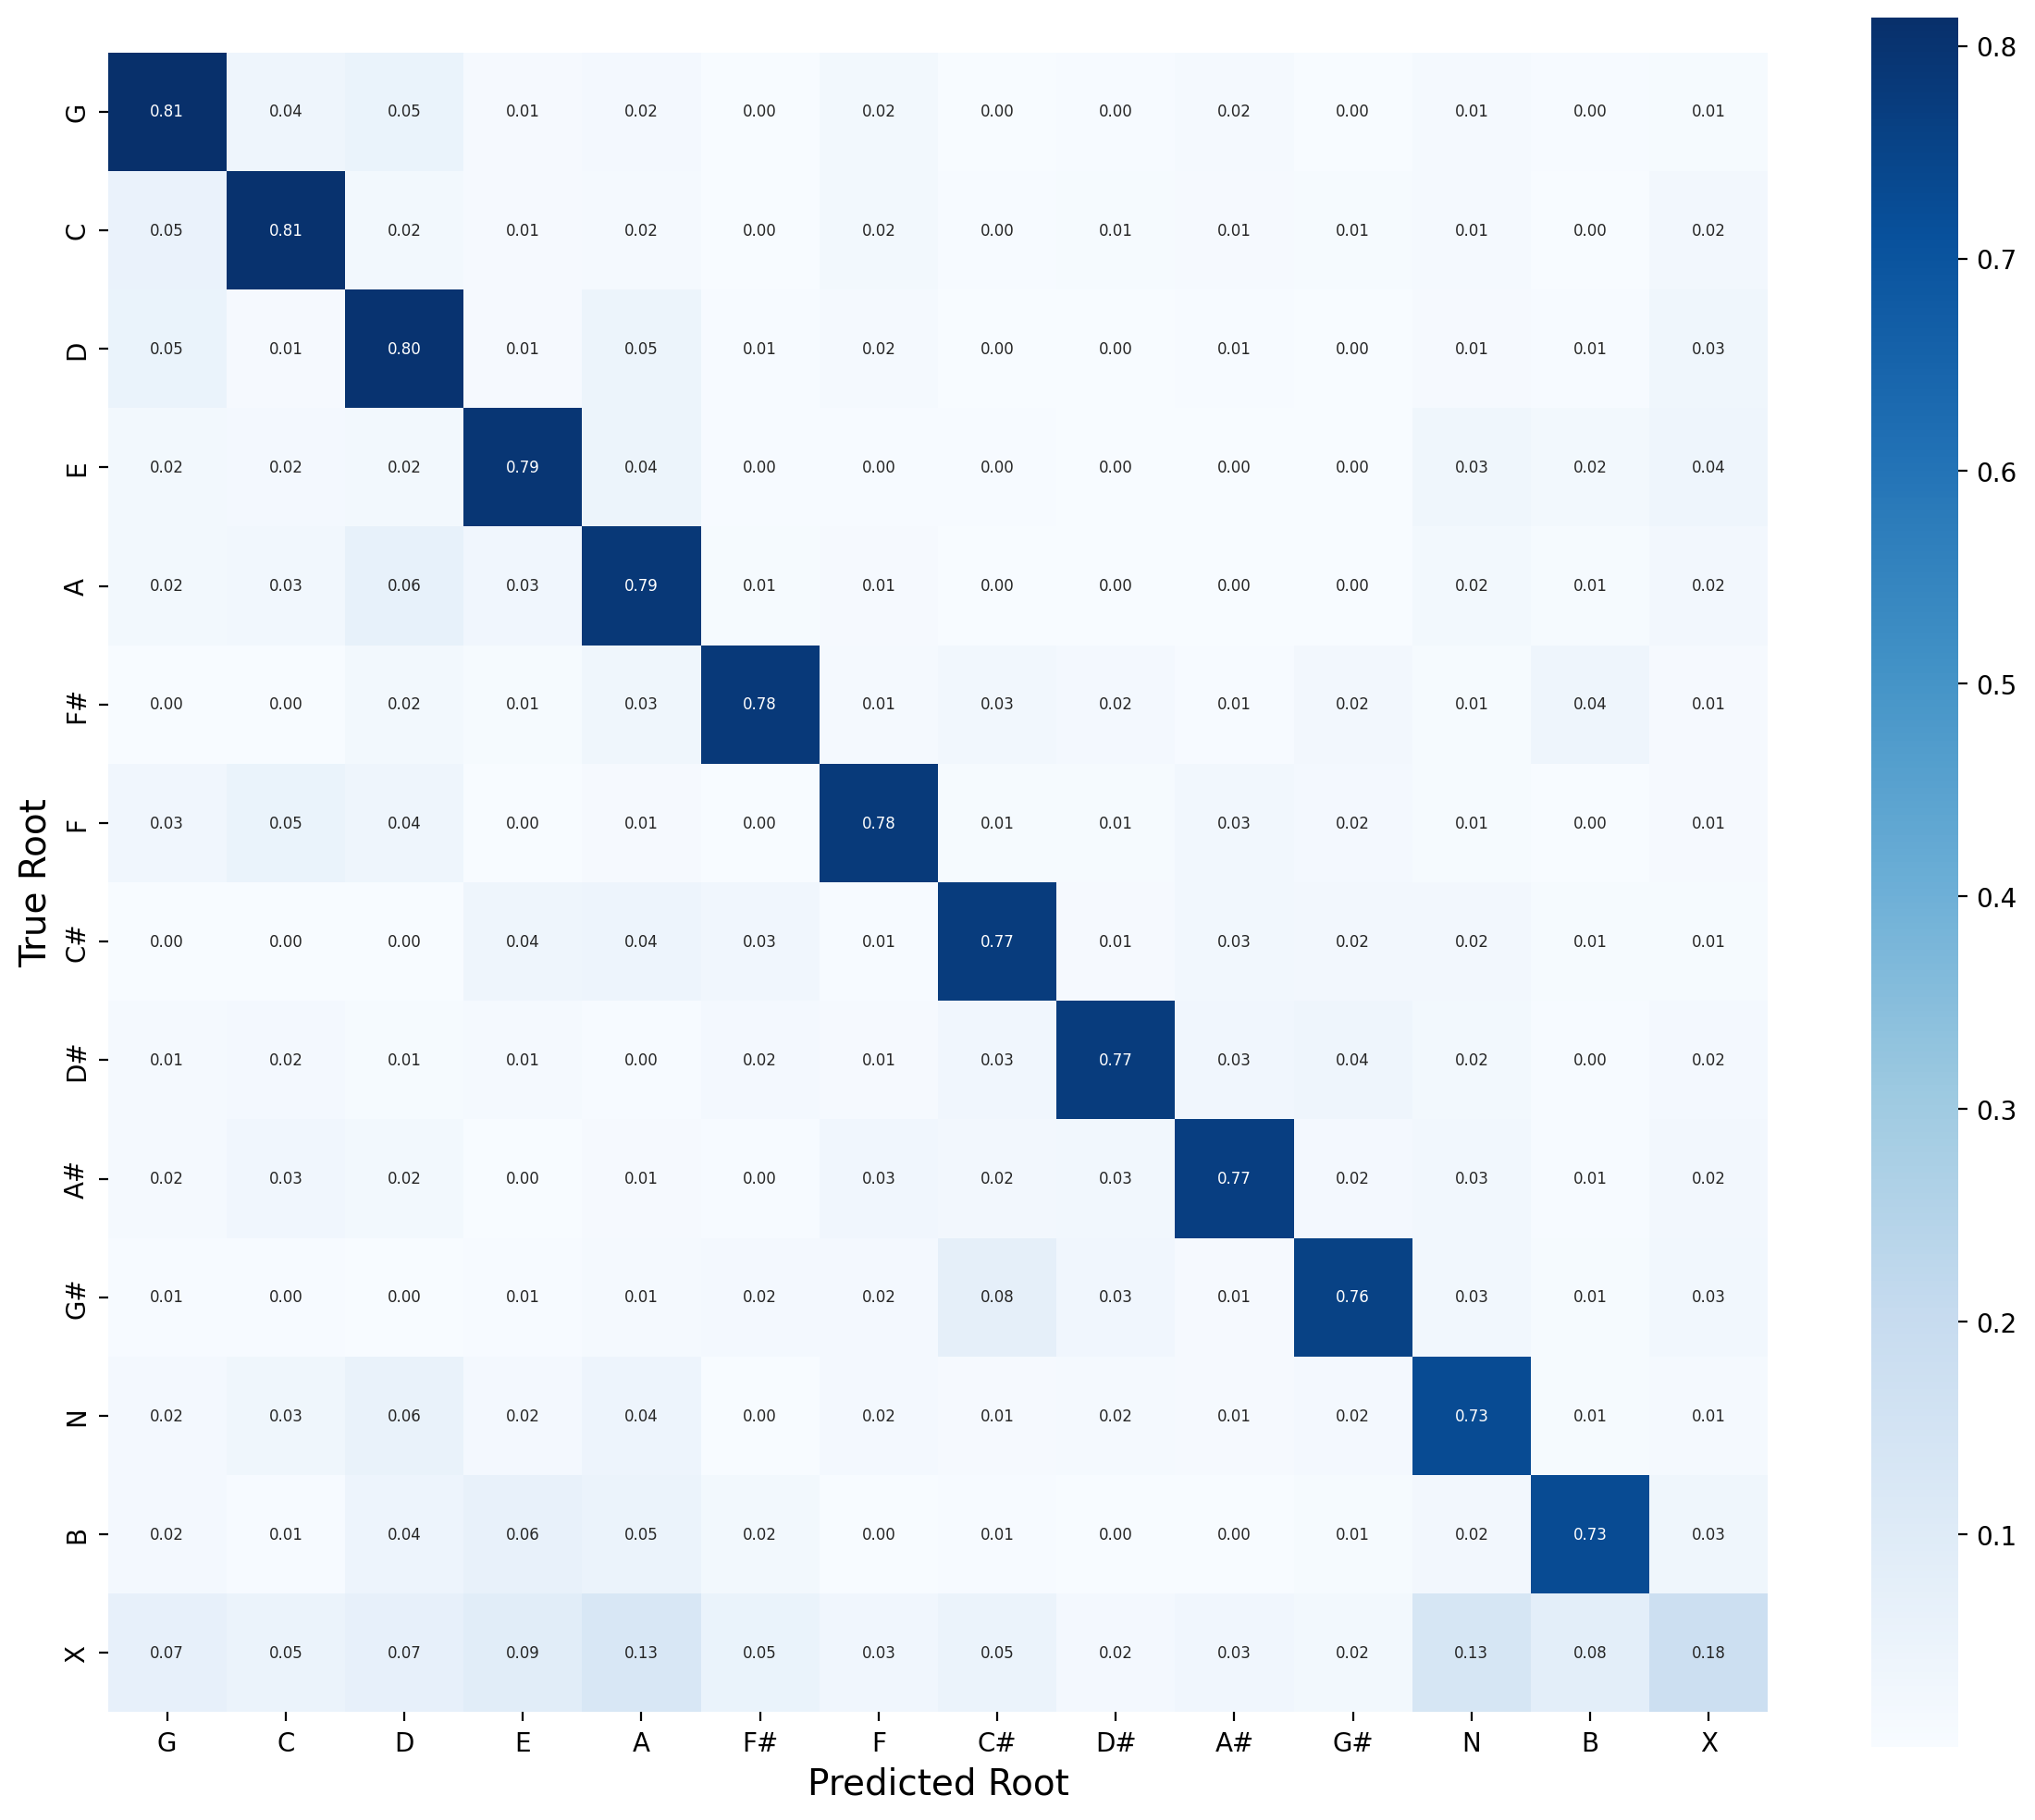

In [39]:
#  Map chord IDs to chord roots
all_labels_root = [get_chord_root(id.item()) for id in all_labels]
all_preds_root = [get_chord_root(id.item()) for id in all_preds]

# Get unique roots and map them to indices
unique_roots = sorted(set(all_labels_root + all_preds_root))
root_to_id = {root: i for i, root in enumerate(unique_roots)}
id_to_root = {i: root for i, root in enumerate(unique_roots)}

# Convert roots to indices for confusion matrix computation
labels_root_idx = [root_to_id[root] for root in all_labels_root]
preds_root_idx = [root_to_id[root] for root in all_preds_root]

# Compute confusion matrix and normalized confusion matrix
cm_root = confusion_matrix(labels_root_idx, preds_root_idx, labels=range(len(unique_roots)))
cm_root_normalized = cm_root.astype('float') / cm_root.sum(axis=1, keepdims=True)

# Reorder both confusion matrices in descending order of diagonal values
order_root = np.argsort(-np.diag(cm_root))  # Raw matrix order
order_root_normalized = np.argsort(-np.diag(cm_root_normalized))  # Normalized matrix order

# Reorder the confusion matrices
cm_root_reordered = cm_root[order_root][:, order_root]
cm_root_normalized_reordered = cm_root_normalized[order_root_normalized][:, order_root_normalized]

# Map reordered indices back to chord roots
root_labels_reordered = [id_to_root[id] for id in order_root]
root_labels_normalized_reordered = [id_to_root[id] for id in order_root_normalized]

# Plot the confusion matrices
fig, axes = plt.subplots(figsize=(12, 10))

# Raw confusion matrix (roots)
# sns.heatmap(cm_root_reordered, annot=True, fmt='d', cmap='Blues', 
#             xticklabels=root_labels_reordered, yticklabels=root_labels_reordered, 
#             ax=axes[0], cbar=True, annot_kws={"fontsize": 6}, square=True)
# axes[0].set_title("Raw Confusion Matrix (Roots)", fontsize=18)
# axes[0].set_xlabel('Predicted Root', fontsize=14)
# axes[0].set_ylabel('True Root', fontsize=14)

# Normalized confusion matrix (roots)
sns.heatmap(cm_root_normalized_reordered, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=root_labels_normalized_reordered, yticklabels=root_labels_normalized_reordered, 
            ax=axes, cbar=True, annot_kws={"fontsize": 6}, square=True)
# axes[1].set_title("Normalized Confusion Matrix (Roots)", fontsize=18)
axes.set_xlabel('Predicted Root', fontsize=14)
axes.set_ylabel('True Root', fontsize=14)
plt.savefig('./thesis/figures/confusion_matrix_roots.png', dpi=200, bbox_inches='tight')
plt.tight_layout()
plt.show()

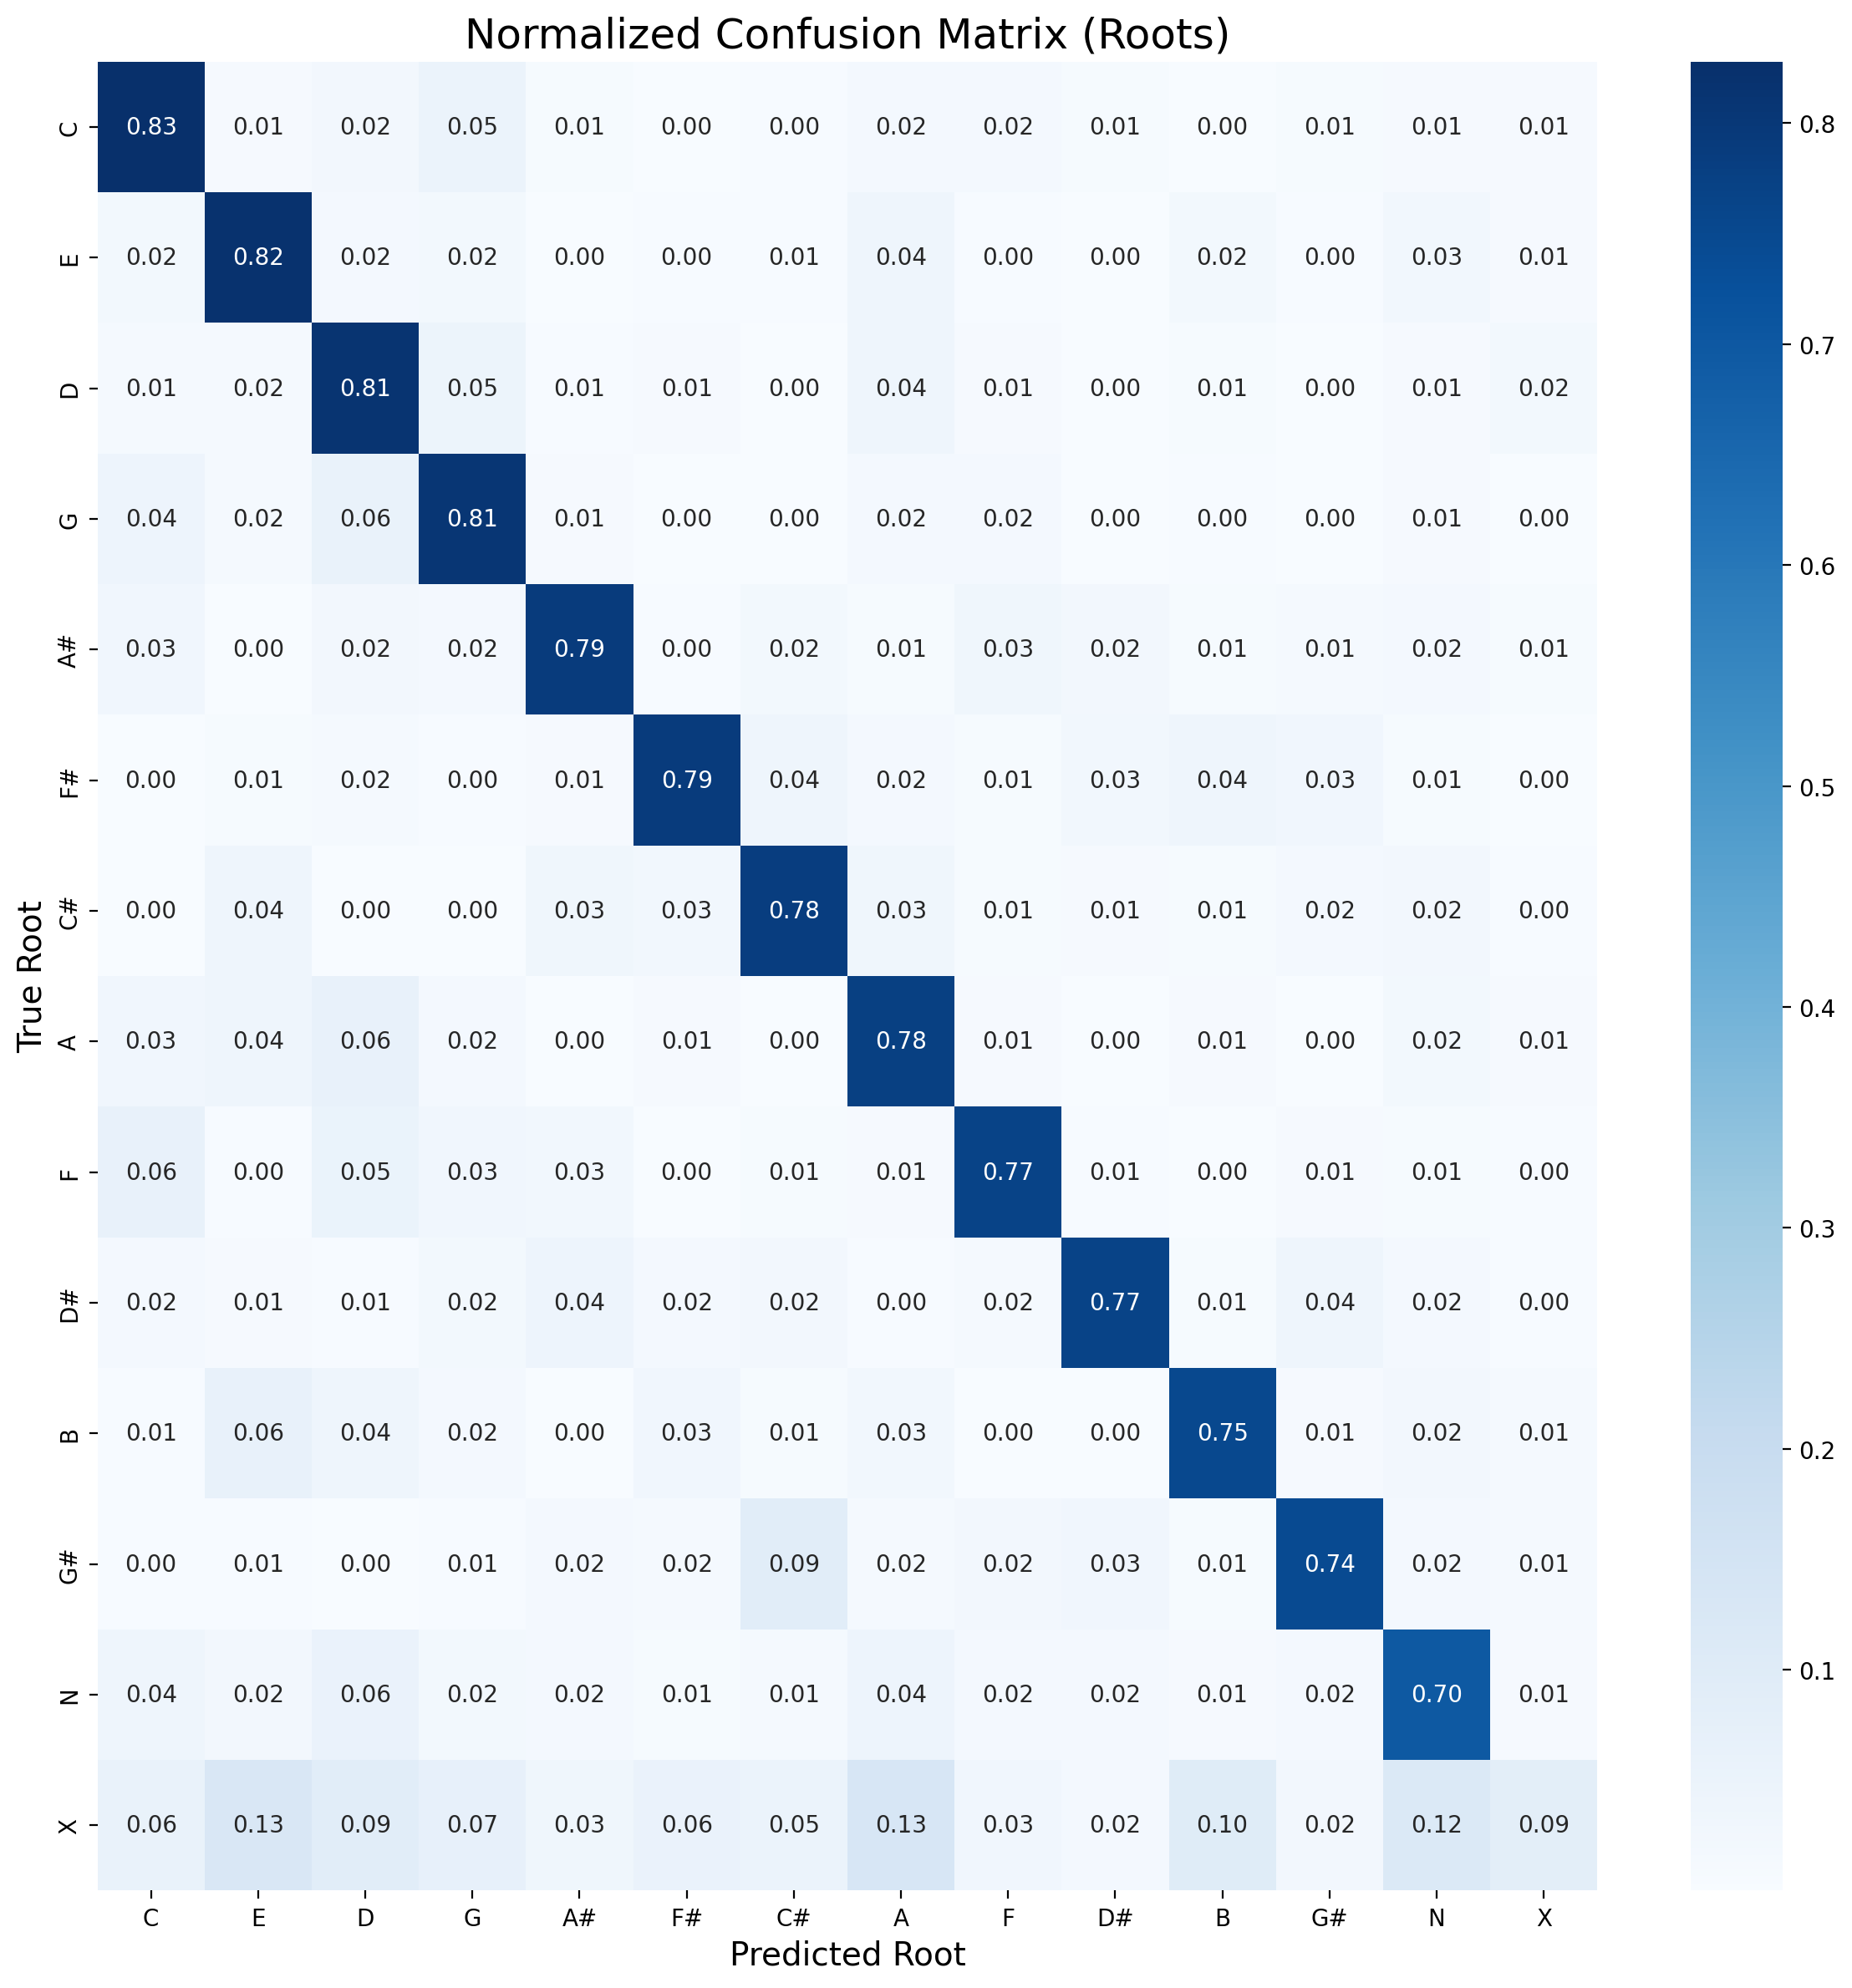

In [ ]:
#  Map chord IDs to chord roots
all_labels_root = [get_chord_root(id.item()) for id in all_labels_weighted]
all_preds_root = [get_chord_root(id.item()) for id in all_preds_weighted]

# Get unique roots and map them to indices
unique_roots = sorted(set(all_labels_root + all_preds_root))
root_to_id = {root: i for i, root in enumerate(unique_roots)}
id_to_root = {i: root for i, root in enumerate(unique_roots)}

# Convert roots to indices for confusion matrix computation
labels_root_idx = [root_to_id[root] for root in all_labels_root]
preds_root_idx = [root_to_id[root] for root in all_preds_root]

# Compute confusion matrix and normalized confusion matrix
cm_root = confusion_matrix(labels_root_idx, preds_root_idx, labels=range(len(unique_roots)))
cm_root_normalized = cm_root.astype('float') / cm_root.sum(axis=1, keepdims=True)

# Reorder both confusion matrices in descending order of diagonal values
order_root = np.argsort(-np.diag(cm_root))  # Raw matrix order
order_root_normalized = np.argsort(-np.diag(cm_root_normalized))  # Normalized matrix order

# Reorder the confusion matrices
cm_root_reordered = cm_root[order_root][:, order_root]
cm_root_normalized_reordered = cm_root_normalized[order_root_normalized][:, order_root_normalized]

# Map reordered indices back to chord roots
root_labels_reordered = [id_to_root[id] for id in order_root]
root_labels_normalized_reordered = [id_to_root[id] for id in order_root_normalized]

# Plot the confusion matrices
fig, axes = plt.subplots(figsize=(12, 12))

# Raw confusion matrix (roots)
# sns.heatmap(cm_root_reordered, annot=True, fmt='d', cmap='Blues', 
#             xticklabels=root_labels_reordered, yticklabels=root_labels_reordered, 
#             ax=axes[0], cbar=True, annot_kws={"fontsize": 6}, square=True)
# axes[0].set_title("Raw Confusion Matrix (Roots)", fontsize=18)
# axes[0].set_xlabel('Predicted Root', fontsize=14)
# axes[0].set_ylabel('True Root', fontsize=14)

# Normalized confusion matrix (roots)
sns.heatmap(cm_root_normalized_reordered, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=root_labels_normalized_reordered, yticklabels=root_labels_normalized_reordered, 
            ax=axes, cbar=True)
axes.set_title("Normalized Confusion Matrix (Roots)", fontsize=18)
axes.set_xlabel('Predicted Root', fontsize=14)
axes.set_ylabel('True Root', fontsize=14)
plt.savefig('./thesis/figures/confusion_matrix_roots.png', dpi=100, bbox_inches='tight')
plt.tight_layout()
plt.show()

## Incorrect Regions, Accuracy over Songs, Accuracy over time

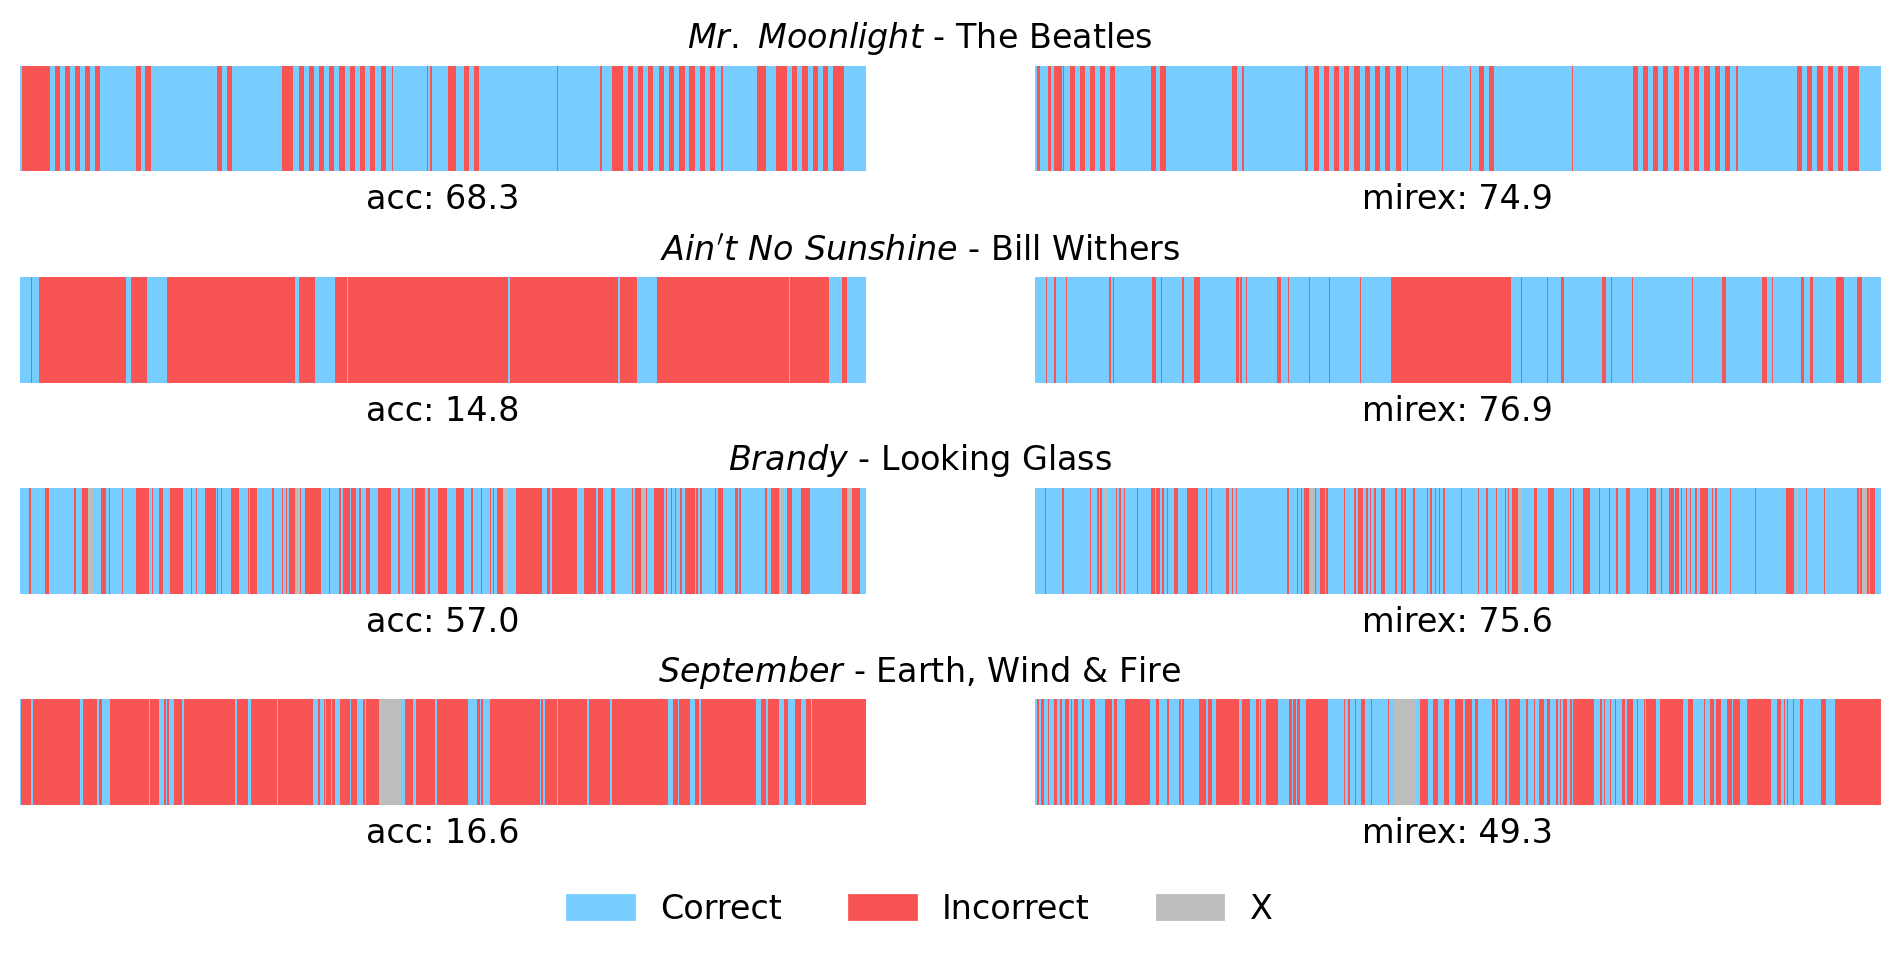

In [26]:
import matplotlib as mpl
from mir_eval.chord import mirex

# Define colormap with an additional color for 'X' chords
cmap = mpl.colors.ListedColormap(["#F95454", "#77CDFF", "#BDBDBD"])
bounds = [0, 0.5, 1.5, 2]  # Adjust bounds to include the 'X' category
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

example_indices = [5,10,3, 8]

model.to('cpu')
dataset = FullChordDataset(val_filenames, dev_mode=True)

fig, axes = plt.subplots(nrows=len(example_indices), ncols=2, figsize=(12, 1.2*len(example_indices)))
for i, (ax, idx) in enumerate(zip(axes, example_indices)):
    cqt, _, labels = dataset[idx]
    with torch.no_grad():
        pred = model(cqt.unsqueeze(0))
        pred_classes = torch.argmax(pred, dim=2).squeeze(0)
    
    # Identify 'X' chords and create a mask
    x_mask = (labels == 1)  # Assuming 'X' is represented as 1

    correctness = (pred_classes == labels).long().numpy()
    labels_chords = [id_to_chord_map[id.item()] for id in labels]
    pred_chords = [id_to_chord_map[id.item()] for id in pred_classes]
    mirex_correctness = mirex(labels_chords, pred_chords)

    # Assign '2' (gray) to 'X' regions
    correctness[x_mask] = 2
    correctness_2d = correctness[np.newaxis, :]
    mirex_correctness[x_mask] = 2
    mirex_correctness_2d = mirex_correctness[np.newaxis, :]

    # Compute accuracy ignoring 'X' frames
    valid_frames = ~x_mask.numpy()
    if valid_frames.sum() > 0:
        accuracy = correctness[valid_frames].sum() / valid_frames.sum()
        mirex_correctness = mirex_correctness[valid_frames].mean()
    else:
        accuracy = 0  # If all frames are 'X', default to 0
        mirex_correctness = 0

    # Get song title
    metadata = get_annotation_metadata(dataset.get_filename(idx))

    # Add vertical space between rows
    if i > 0:
        fig.subplots_adjust(hspace=1)

    # Add song title centered above each row
    title = ' '.join([word.capitalize() for word in metadata['title'].split()])
    latex_title = title.replace(" ", "~")
    fig.text(
        0.5,
        ax[0].get_position().y1 + 0.01,
        f"$\\mathit{{{latex_title}}}$ - {metadata['artist']}",
        ha='center',
        va='bottom',
        fontsize=12
    )



    # Plot correctness
    ax[0].imshow(correctness_2d, cmap=cmap, norm=norm, aspect="auto")
    ax[0].set_yticks([])
    ax[0].set_xticks([]) 

    ax[0].set_xlabel(f"acc: {round(accuracy * 100, 1)}", fontsize=12)
    ax[1].set_xlabel(f"mirex: {round(mirex_correctness * 100, 1)}", fontsize=12)

    for spine in ax[0].spines.values():
        spine.set_visible(False)
    for spine in ax[1].spines.values():
        spine.set_visible(False)

    # Plot MIREX correctness
    ax[1].imshow(mirex_correctness_2d, cmap=cmap, norm=norm, aspect="auto")
    # Put title below plot
    # ax[1].set_title(f"MIREX {round(mirex_correctness, 3)}", fontsize=12, 
    ax[1].set_yticks([])
    ax[1].set_xticks([])

import matplotlib.patches as mpatches

# Define legend patches
legend_patches = [
    mpatches.Patch(color="#77CDFF", label="Correct"),
    mpatches.Patch(color="#F95454", label="Incorrect"),
    mpatches.Patch(color="#BDBDBD", label="X")
]

# Add legend with extra spacing below the figure
fig.legend(handles=legend_patches, loc="upper center", bbox_to_anchor=(0.5, 0.05), 
           ncol=3, fontsize=12, frameon=False)

plt.savefig('./thesis/figures/chord_recognition_examples.png', dpi=100, bbox_inches='tight')
plt.show()

In [11]:
model.to('cpu')

indices = [5,10,3, 8]
for idx in indices:
    print(f"\nSong idx: {idx}, Title: {get_annotation_metadata(dataset.get_filename(idx))['title']}")
    
    cqt, label = dataset[idx]
    with torch.no_grad():
        pred = model(cqt.unsqueeze(0))
        pred_classes = torch.argmax(pred, dim=2).squeeze(0)

    true_chords = list(map(id_to_chord_map.get, label.numpy()))
    pred_chords = list(map(id_to_chord_map.get, pred_classes.cpu().numpy()))

    print("True Chords:     " + " ".join(f"{chord:>8}" for chord in true_chords))
    print("Predicted Chords:" + " ".join(f"{chord:>8}" for chord in pred_chords))


Song idx: 5, Title: Mr. Moonlight
True Chords:            N        N        N        N        N   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj  F#:sus4  F#:sus4  F#:sus4  F#:sus4  F#:sus4  F#:sus4  F#:sus4  F#:sus4  F#:sus4  F#:sus4   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj  F#:sus4  F#:sus4  F#:sus4  F#:sus4  F#:sus4  F#:sus4  F#:sus4  F#:sus4  F#:sus4  F#:sus4   F#:maj   F#:maj   F#:maj   F#:maj   F#:maj   F

## Performance Across Songs/Time

In [6]:
from itertools import groupby
from mir_eval.chord import mirex


dataset = FullChordDataset(val_filenames, dev_mode=True)
model.to('cpu')

# For histograms
all_accuracies = []
all_mirexes = []

# For incorrect region analysis
incorrect_region_lengths = []
incorrect_frame_with_different_neighbors = 0
total_incorrect_frames = 0
single_frame_regions = 0

# For average accuracy over time
max_length = max([len(dataset[idx][2]) for idx in range(len(dataset))])  # Longest song length
correctness_matrix = np.zeros((len(dataset), max_length))  # Rows: Songs, Columns: Time steps
valid_frames = np.zeros(max_length)  # To count valid entries at each time step

# Unified loop
for idx in tqdm(range(len(dataset))):
    cqt, _, label = dataset[idx]
    with torch.no_grad():
        pred = model(cqt.unsqueeze(0))
        pred_classes = torch.argmax(pred, dim=2).squeeze(0)
    
    correctness = (pred_classes == label).long().numpy()
    incorrect_mask = correctness == 0

    region_mask = pred_classes + 2 # Shift by 2 to avoid confusion with 'X' and 'N' chords
    region_mask[correctness == 1] = 0  # Set correct chords to 0

    # Incorrect region analysis
    region_lengths = [len(list(group)) for val, group in groupby(region_mask) if val != 0]
    incorrect_region_lengths.extend(region_lengths)
    single_frame_regions += region_lengths.count(1)
    total_incorrect_frames += np.sum(incorrect_mask)

    # Count incorrect frames with different neighbors
    for i in range(1, len(correctness) - 1):
        if correctness[i] == 0 and region_mask[i - 1] != region_mask[i] and region_mask[i + 1] != region_mask[i]:
            incorrect_frame_with_different_neighbors += 1

    # Average accuracy over time
    correctness_matrix[idx, :len(correctness)] = correctness
    valid_frames[:len(correctness)] += 1

    # Accuracy for the histogram ignore 'X' frames
    mask_x = (label == 1)
    accuracy = correctness[~mask_x.numpy()].sum() / (~mask_x.numpy()).sum()
    all_accuracies.append(accuracy)

    # MIREX histogram, ignoring 'X' frames
    true_chords = list(map(id_to_chord_map.get, label[~mask_x].numpy()))
    pred_chords = list(map(id_to_chord_map.get, pred_classes[~mask_x].numpy()))
    mirex_score = mirex(true_chords, pred_chords)
    all_mirexes.append(np.mean(mirex_score))

100%|██████████| 241/241 [00:52<00:00,  4.57it/s]


In [7]:
# Get indicies of the bottom 10 Mirexes with their corresponding values
bottom_10_indices = np.argsort(all_mirexes)[:10]
bottom_10_accuracies = [all_mirexes[idx] for idx in bottom_10_indices]
for idx, accuracy in zip(bottom_10_indices, bottom_10_accuracies):
    print(f"Song idx: {idx}, Title: {get_annotation_metadata(dataset.get_filename(idx))['title']}, Accuracy: {accuracy}")

Song idx: 128, Title: Quarter to Three, Accuracy: 0.1918568784700802
Song idx: 23, Title: Everybody Loves Somebody, Accuracy: 0.2715466351829988
Song idx: 152, Title: , Accuracy: 0.33407572383073497
Song idx: 9, Title: Black Balloon, Accuracy: 0.43447669305189096
Song idx: 204, Title: I Like The Way (91), Accuracy: 0.44011406844106465
Song idx: 8, Title: September, Accuracy: 0.4928940568475452
Song idx: 233, Title: Baby Don't Forget My Number (Subway Mix), Accuracy: 0.4992729035385361
Song idx: 174, Title: City In The Sky (Single Version), Accuracy: 0.5192706174886034
Song idx: 221, Title: , Accuracy: 0.526123492875411
Song idx: 169, Title: (You're So Square) Baby, I Don't Care, Accuracy: 0.5274151436031331


In [8]:
# Top 10 diffs between Mirex and accuracy
diffs = np.array(all_mirexes) - np.array(all_accuracies)
top_10_diffs = np.argsort(diffs)[-10:]
top_10_diff_values = [diffs[idx] for idx in top_10_diffs]
for idx, diff in zip(top_10_diffs, top_10_diff_values):
    print(f"Song idx: {idx}, Title: {get_annotation_metadata(dataset.get_filename(idx))['title']}, Diff: {diff}")

Song idx: 62, Title: I Don't Want Your Love (Shep Pettibone 7'' Mix), Diff: 0.5204622051035146
Song idx: 110, Title: 9 loons, Diff: 0.5311572700296736
Song idx: 27, Title: That's The Way I Feel About 'Cha, Diff: 0.5359505955006617
Song idx: 112, Title: Amor, Diff: 0.5596192384769538
Song idx: 37, Title: Wanna Be Startin' Somethin', Diff: 0.5653979238754325
Song idx: 209, Title: Flesh For Fantasy (1999 Digital Remaster), Diff: 0.5963442498095963
Song idx: 10, Title: Ain't No Sunshine, Diff: 0.6216017634092579
Song idx: 22, Title: Birthday, Diff: 0.6506373117033604
Song idx: 151, Title: Beautiful, Diff: 0.66810551558753
Song idx: 85, Title: Smoking Gun, Diff: 0.7286230429546368


In [9]:
# Final computations and plots
percent_single_frame_regions = (single_frame_regions / len(incorrect_region_lengths)) * 100 if incorrect_region_lengths else 0
percent_incorrect_with_different_neighbors = (incorrect_frame_with_different_neighbors / total_incorrect_frames) * 100 if total_incorrect_frames else 0
average_accuracy_over_time = correctness_matrix.sum(axis=0) / valid_frames

# Print percentages
print(f"Percentage of incorrect regions that are 1 frame wide: {percent_single_frame_regions:.2f}%")
print(f"Percentage of incorrect frames with different neighbors on both sides: {percent_incorrect_with_different_neighbors:.2f}%")

Percentage of incorrect regions that are 1 frame wide: 26.67%
Percentage of incorrect frames with different neighbors on both sides: 3.71%


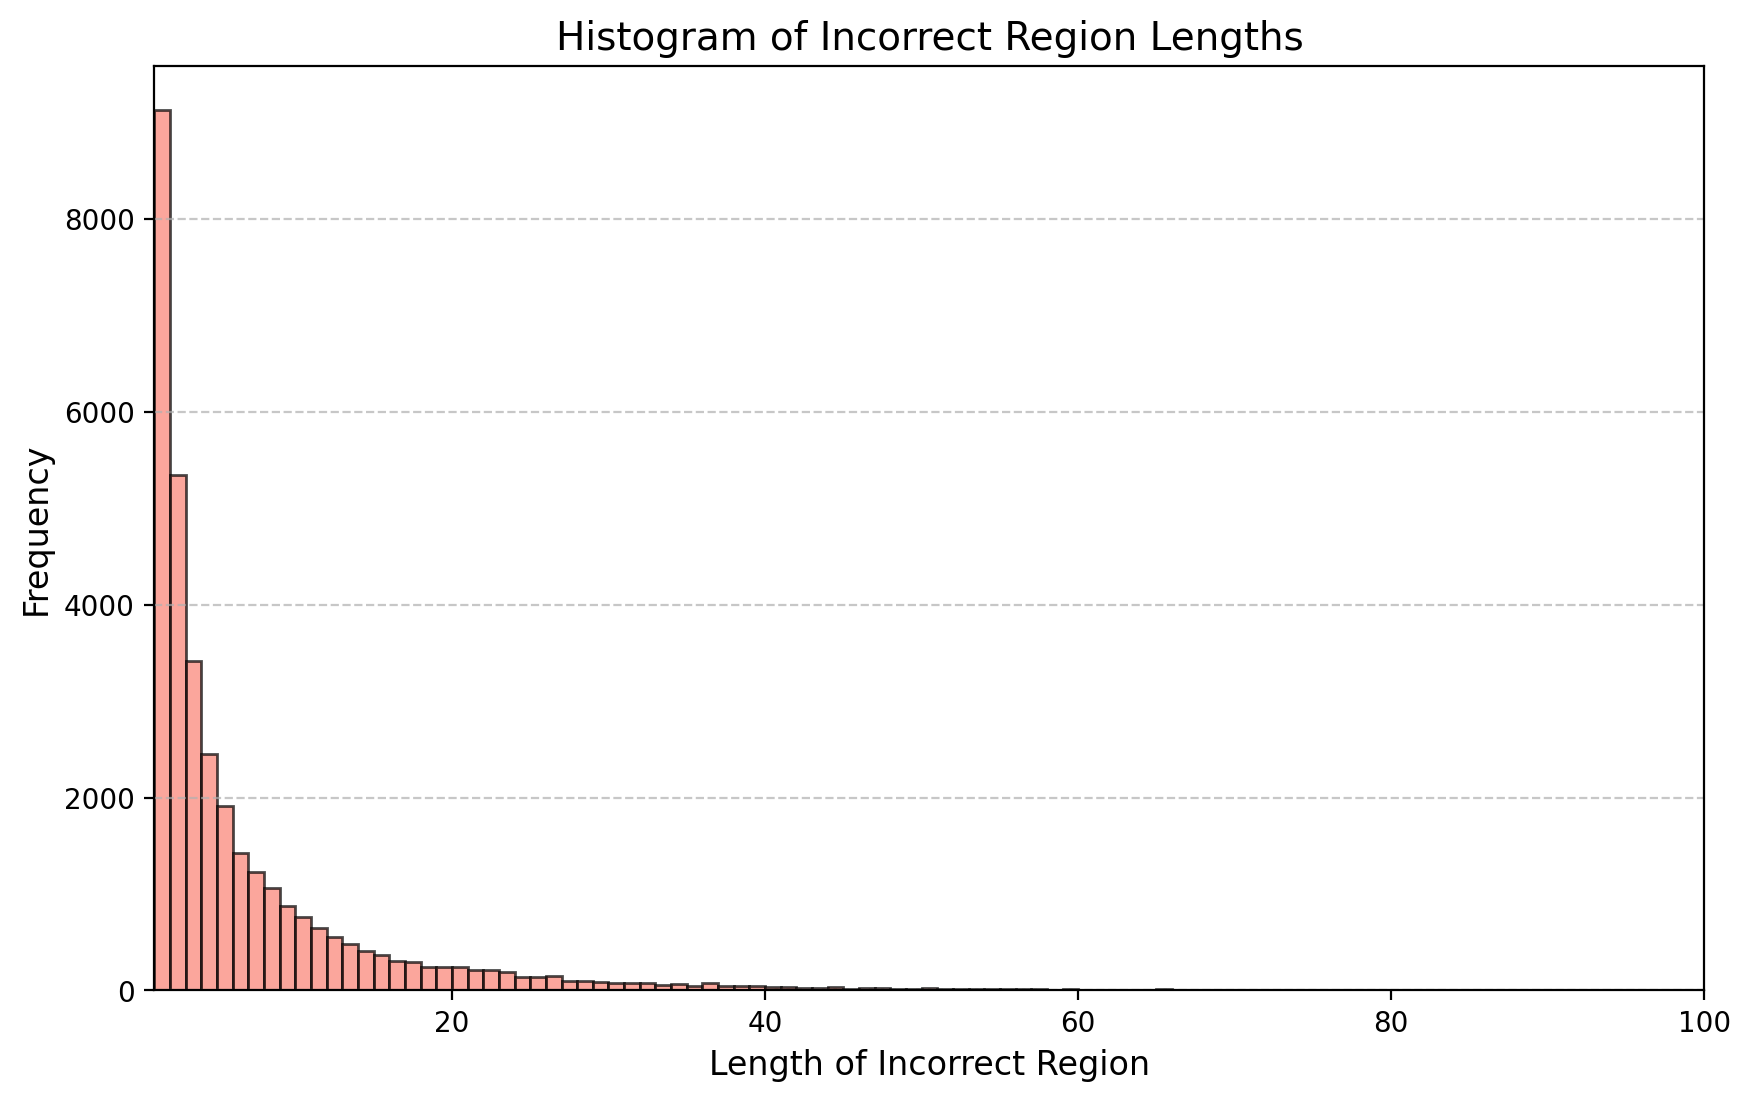

In [ ]:
# Incorrect region histogram
plt.figure(figsize=(10, 6))
plt.hist(incorrect_region_lengths, bins=range(1, max(incorrect_region_lengths) + 2), alpha=0.7, color='salmon', edgecolor='black')
plt.xlim(1, 100)
plt.title("Histogram of Incorrect Region Lengths", fontsize=14)
plt.xlabel("Length of Incorrect Region", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('./thesis/figures/incorrect_region_histogram.png', dpi=100, bbox_inches='tight')
plt.show()

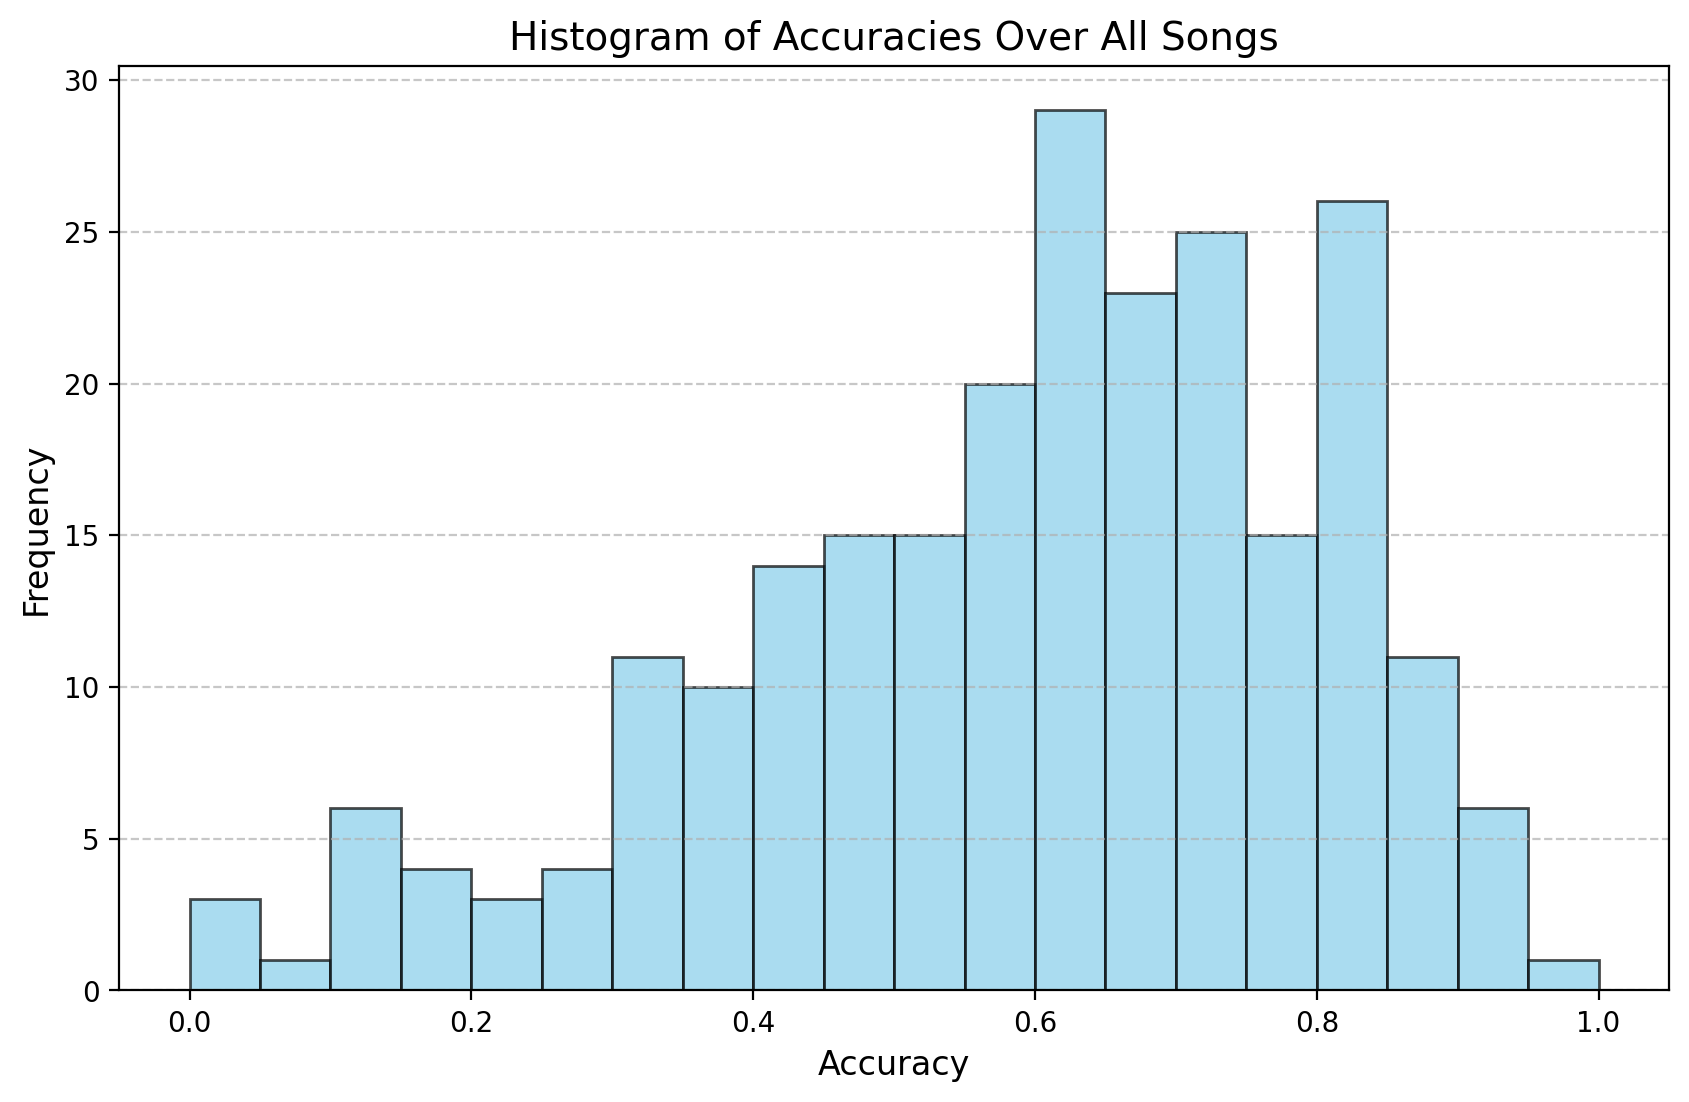

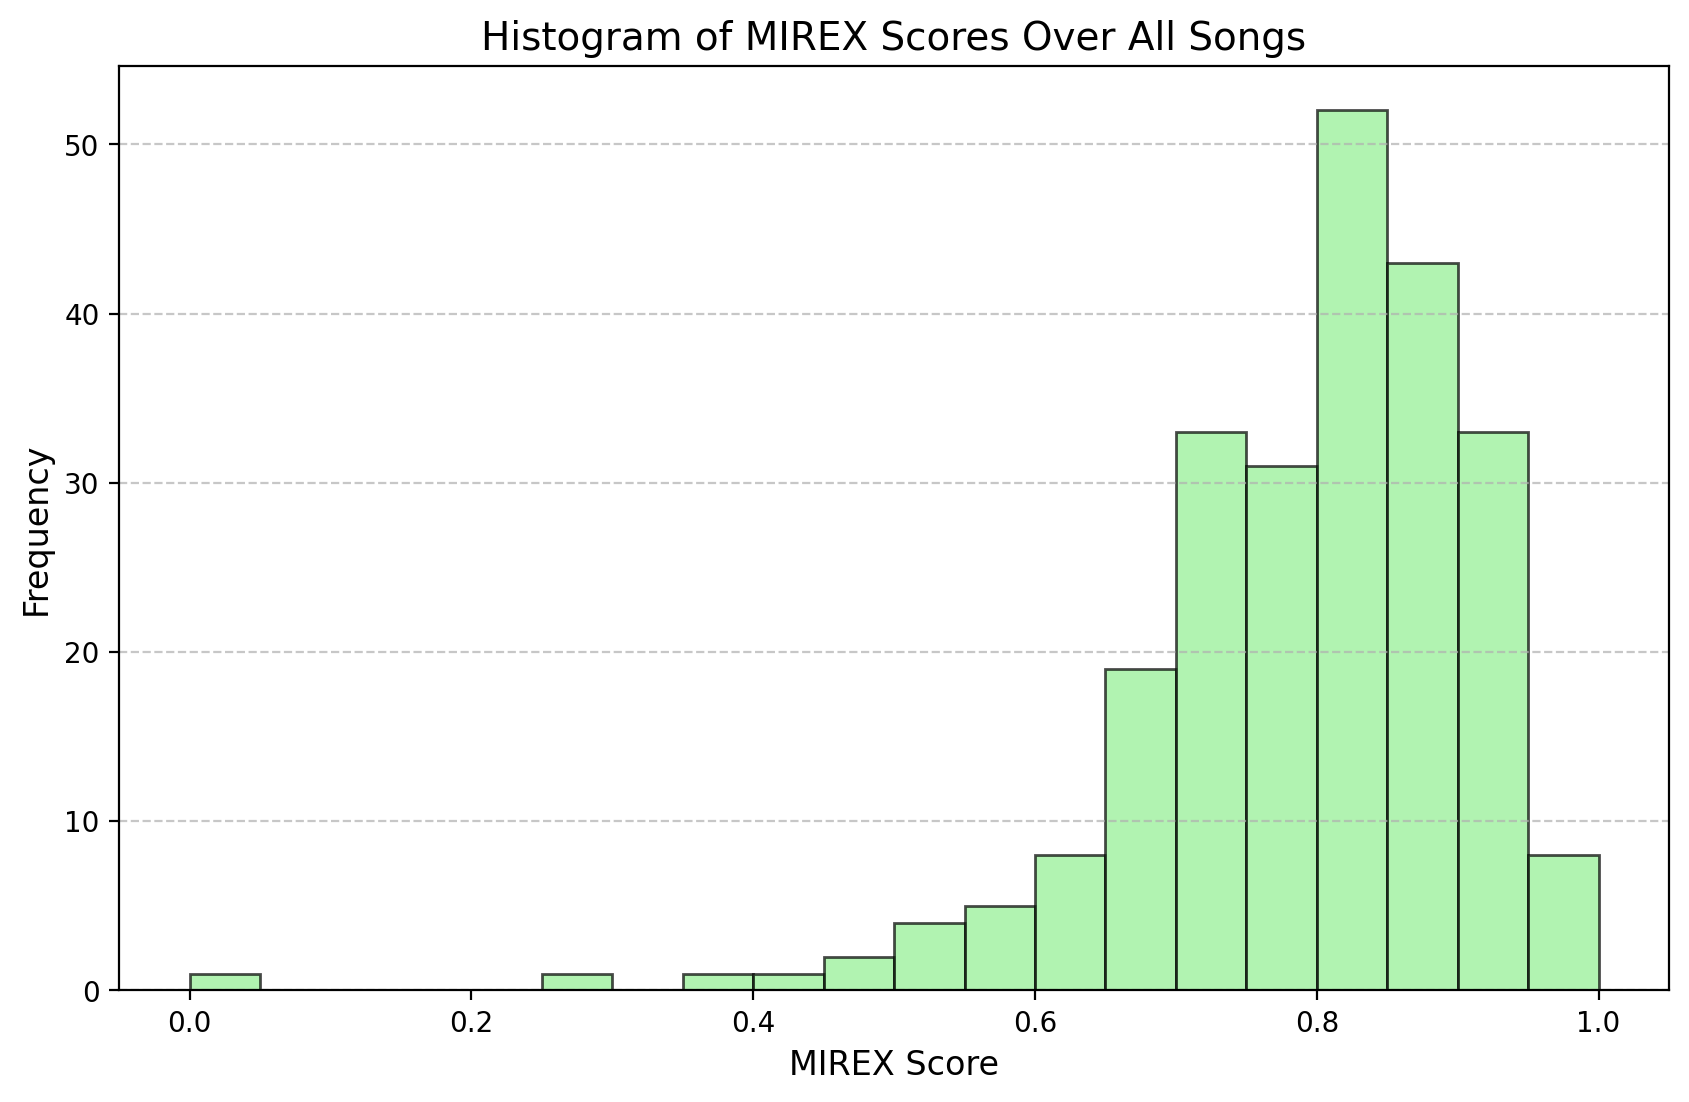

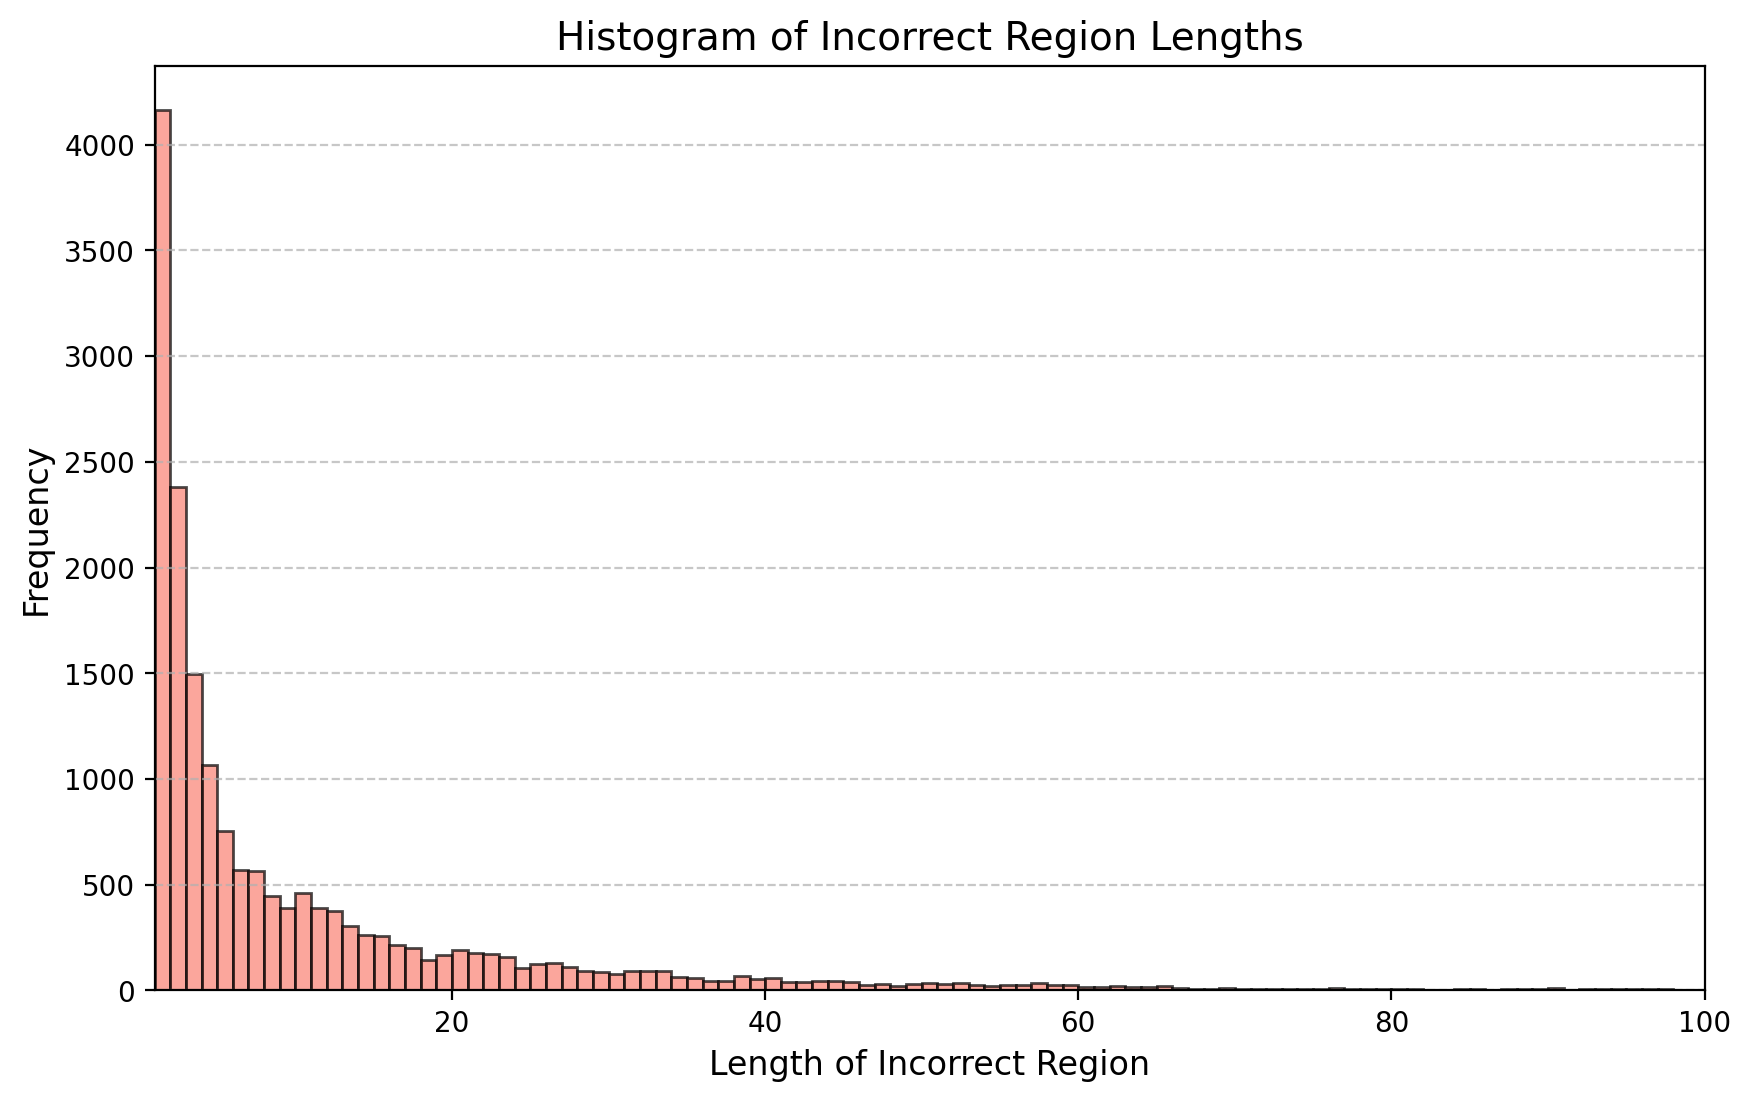

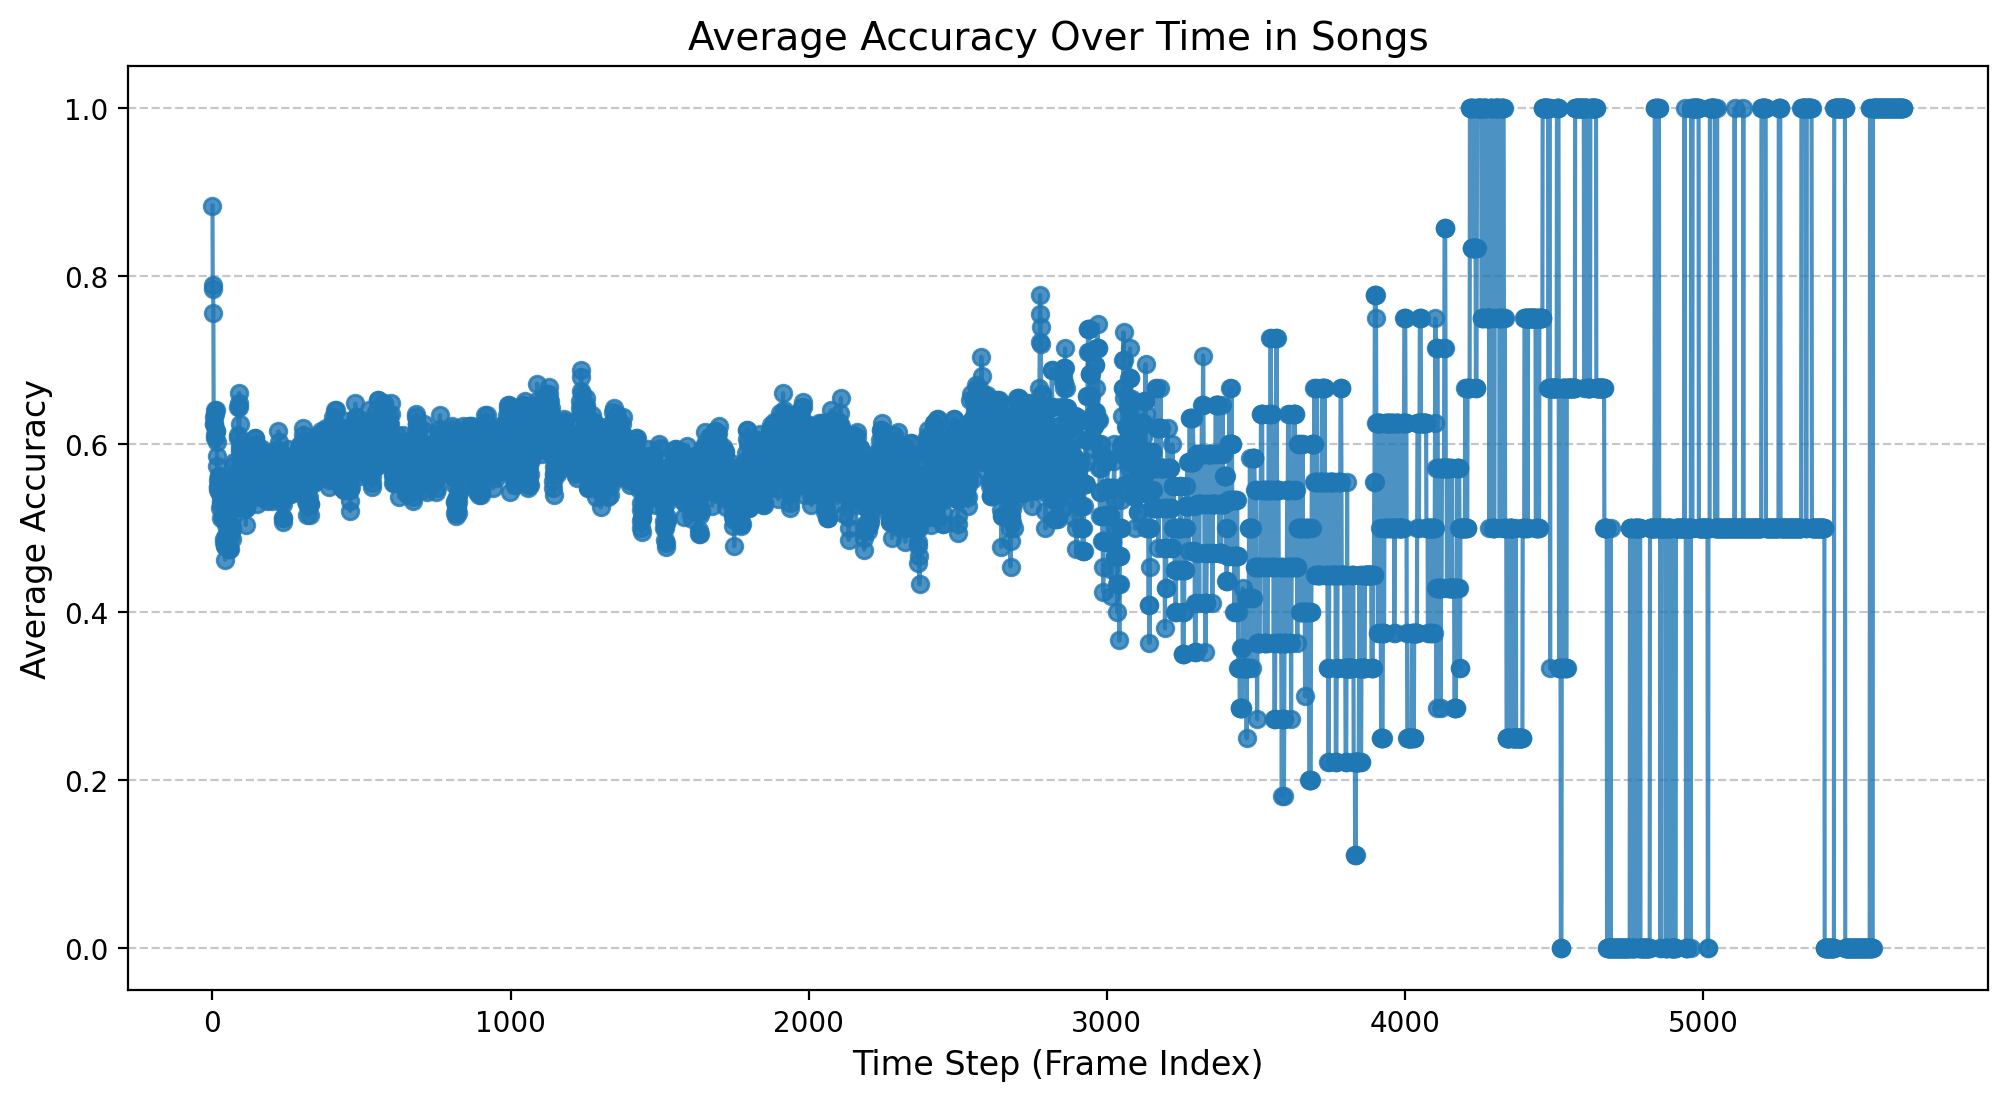

Percentage of incorrect regions that are 1 frame wide: 23.22%
Percentage of incorrect frames with correct neighbors on both sides: 1.71%


In [ ]:
# Accuracy histogram
plt.figure(figsize=(10, 6))
plt.hist(all_accuracies, bins=20, range=(0, 1), alpha=0.7, color='skyblue', edgecolor='black')
plt.title("Histogram of Accuracies Over All Songs", fontsize=14)
plt.xlabel("Accuracy", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# MIREX histogram
plt.figure(figsize=(10, 6))
plt.hist(all_mirexes, bins=20, range=(0, 1), alpha=0.7, color='lightgreen', edgecolor='black')
plt.title("Histogram of MIREX Scores Over All Songs", fontsize=14)
plt.xlabel("MIREX Score", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Incorrect region histogram
plt.figure(figsize=(10, 6))
plt.hist(incorrect_region_lengths, bins=range(1, max(incorrect_region_lengths) + 2), alpha=0.7, color='salmon', edgecolor='black')
plt.xlim(1, 100)
plt.title("Histogram of Incorrect Region Lengths", fontsize=14)
plt.xlabel("Length of Incorrect Region", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Average accuracy over time plot
plt.figure(figsize=(12, 6))
plt.plot(average_accuracy_over_time, marker='o', linestyle='-', alpha=0.8)
plt.title("Average Accuracy Over Time in Songs", fontsize=14)
plt.xlabel("Time Step (Frame Index)", fontsize=12)
plt.ylabel("Average Accuracy", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

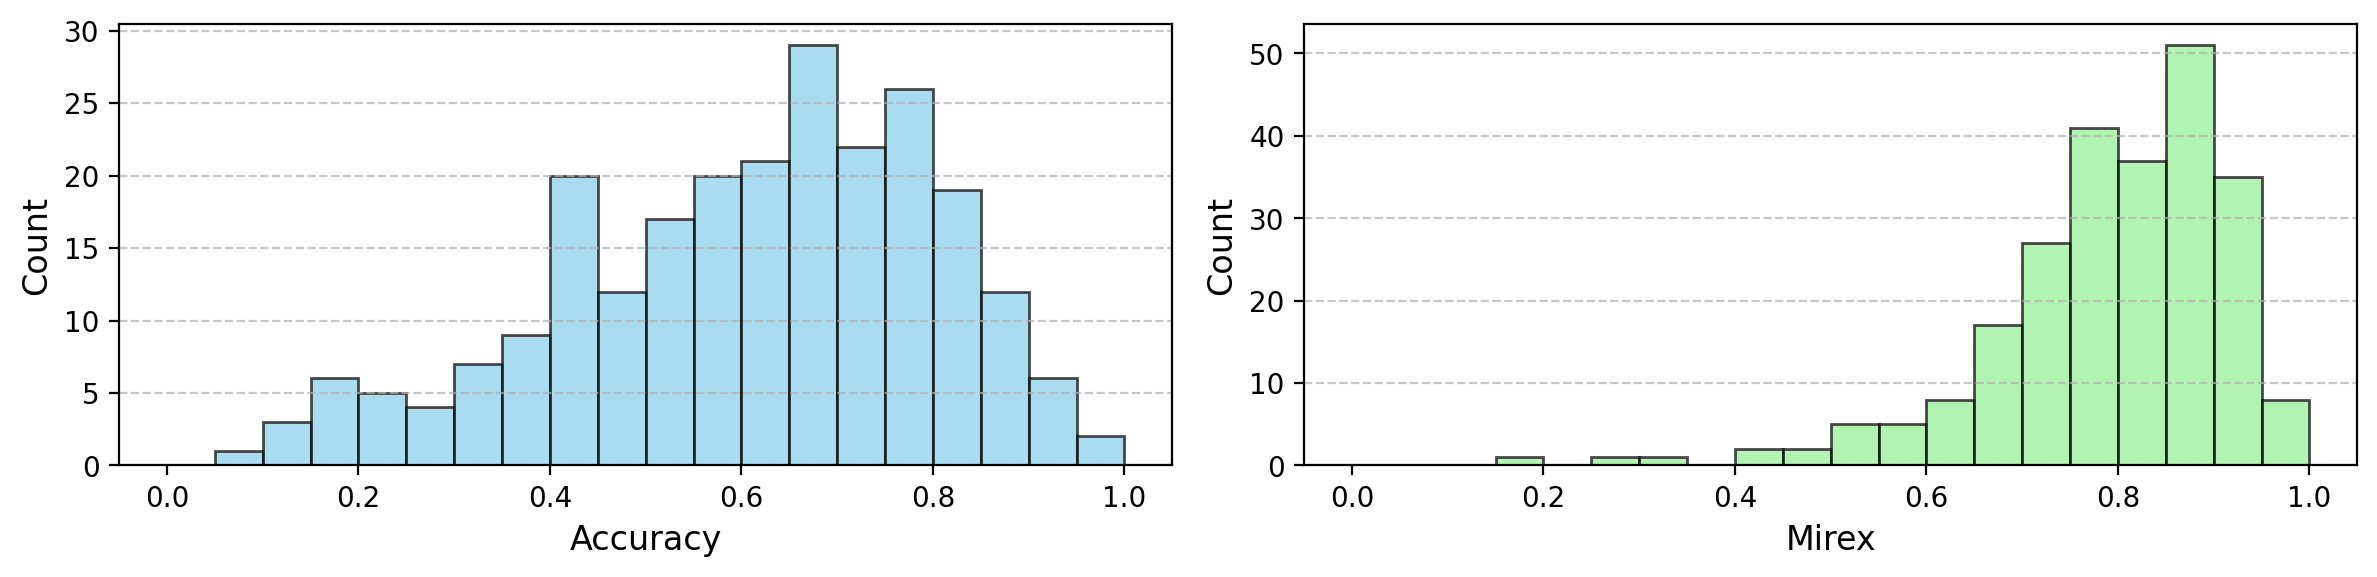

In [12]:
# Plot the two histograms of accuracy and MIREX scores side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 3))

# Accuracy histogram
axes[0].hist(all_accuracies, bins=20, range=(0, 1), alpha=0.7, color='skyblue', edgecolor='black')
# axes[0].set_title("Histogram of Song Accuracies", fontsize=14)
axes[0].set_xlabel("Accuracy", fontsize=12)
axes[0].set_ylabel("Count", fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# MIREX histogram
axes[1].hist(all_mirexes, bins=20, range=(0, 1), alpha=0.7, color='lightgreen', edgecolor='black')
# axes[1].set_title("Histogram of Song MIREX Scores", fontsize=14)
axes[1].set_xlabel("Mirex", fontsize=12)
axes[1].set_ylabel("Count", fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('./thesis/figures/accuracy_mirex_histograms.png', dpi=100, bbox_inches='tight')
plt.show()

In [74]:
# What portion of accuracies are below 0.4
below_40 = sum(accuracy < 0.4 for accuracy in all_accuracies)
print(f"Portion of accuracies below 0.4: {below_40 / len(all_accuracies):.2f}")

# Portion between 0.4 and 0.6
between_40_60 = sum(0.4 <= accuracy < 0.8 for accuracy in all_accuracies)
print(f"Portion of accuracies between 0.4 and 0.6: {between_40_60 / len(all_accuracies):.2f}")

# Below 0.6 in`` MIREX
below_60_mirex = sum(mirex < 0.6 for mirex in all_mirexes)
print(f"Portion of MIREX scores below 0.6: {below_60_mirex / len(all_mirexes):.2f}")

# Mean difference between MIREX and accuracy
diffs = np.array(all_mirexes) - np.array(all_accuracies)
mean_diff = np.mean(diffs)
print(f"Mean difference between MIREX and accuracy: {mean_diff:.3f}")

Portion of accuracies below 0.4: 0.15
Portion of accuracies between 0.4 and 0.6: 0.69
Portion of MIREX scores below 0.6: 0.07
Mean difference between MIREX and accuracy: 0.187


## Transition Frame Accuracy

In [41]:
from src.utils import HOP_LENGTH, SR, get_chord_annotation
from sklearn.metrics import accuracy_score

all_transitions = []
dataset = FullChordDataset(val_filenames, dev_mode=True)

for i in tqdm(range(len(dataset))):
    filename = dataset.get_filename(i)
    _, transitions = get_chord_annotation(filename, return_transitions=True, frame_length= HOP_LENGTH / SR)
    _,_, labels = dataset[i]
    all_transitions.extend(transitions[:labels.shape[0]].tolist())

all_transitions = np.array(all_transitions)

100%|██████████| 241/241 [00:09<00:00, 24.25it/s]


In [42]:
# Compute overall accuracy ignoring X chords
mask_x = (all_labels == 1)
overall_acc = accuracy_score(all_labels[~mask_x], all_preds[~mask_x])

# Identify which indices are transitions vs non-transitions
transition_indices = [i for i, t in enumerate(all_transitions) if t]
non_transition_indices = [i for i, t in enumerate(all_transitions) if not t]

labels_transition = np.array([all_labels[i] for i in transition_indices])
preds_transition = np.array([all_preds[i] for i in transition_indices])
labels_non_transition = np.array([all_labels[i] for i in non_transition_indices])
preds_non_transition = np.array([all_preds[i] for i in non_transition_indices])

mask_x_transition = (np.array(labels_transition) == 1)
mask_x_non_transition = (np.array(labels_non_transition) == 1)

transition_acc = accuracy_score(labels_transition[~mask_x_transition], preds_transition[~mask_x_transition])
non_transition_acc = accuracy_score(labels_non_transition[~mask_x_non_transition], preds_non_transition[~mask_x_non_transition])

print("Overall Accuracy:", overall_acc)
print("Transition Frames Accuracy:", transition_acc)
print("Non-Transition Frames Accuracy:", non_transition_acc)

Overall Accuracy: 0.6007075225541125
Transition Frames Accuracy: 0.37035079874801835
Non-Transition Frames Accuracy: 0.6115736391003394


In [44]:
# Percentage of frames that are transitions
num_transitions = sum(all_transitions)
print("Fraction of frames that are transitions:", round(num_transitions / len(all_transitions) * 100, 5))

Fraction of frames that are transitions: 4.411


## Context Lengths



### Different Context Lengths

In [67]:
from src.data.dataset import FixedLengthChordDataset
from sklearn.metrics import accuracy_score

context_lengths = [5, 10, 20, 60]
accuracies = []
device = get_torch_device()
model.eval()
model.to(device)

for context_length in context_lengths:
    print(f"Context length: {context_length}")
    dataset = FixedLengthChordDataset(segment_length=context_length, filenames=val_filenames, dev_mode=True)
    loader = DataLoader(dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
    all_preds_context = []
    all_labels_context = []
    for batch_cqt, _, batch_labels in tqdm(loader):
        batch_cqt, batch_labels = batch_cqt.to(device), batch_labels.to(device)
        batch_preds = model(batch_cqt)
        batch_preds = torch.argmax(batch_preds, dim=2).cpu()
        all_preds_context.extend(torch.flatten(batch_preds).tolist())
        all_labels_context.extend(torch.flatten(batch_labels).tolist())

    all_labels_context = torch.tensor(all_labels_context)
    all_preds_context = torch.tensor(all_preds_context)
    mask = torch.logical_and(all_labels_context != -1, all_labels_context != 1) # Ignore padded and 'X' chords
    all_preds_context = all_preds_context[mask]
    all_labels_context = all_labels_context[mask]
    accuracy = accuracy_score(all_labels_context, all_preds_context) * 100
    accuracies.append(accuracy)

Context length: 5


100%|██████████| 341/341 [00:19<00:00, 17.42it/s]


Context length: 10


100%|██████████| 171/171 [00:17<00:00,  9.66it/s]


Context length: 20


100%|██████████| 87/87 [00:18<00:00,  4.59it/s]


Context length: 60


100%|██████████| 32/32 [00:18<00:00,  1.77it/s]


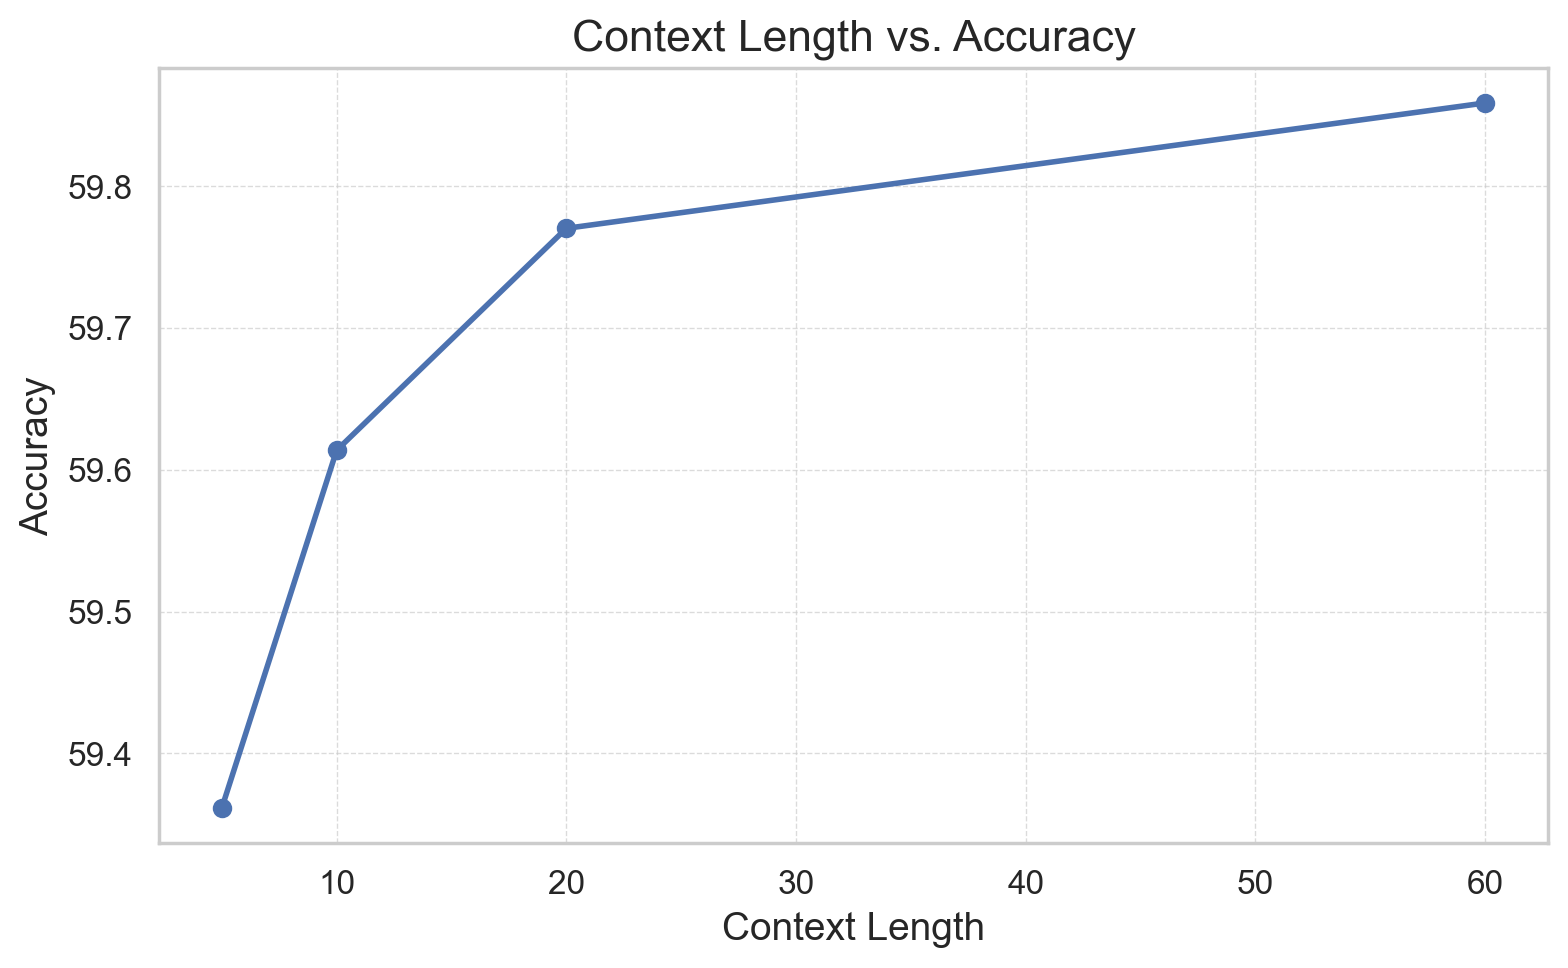

In [69]:
import seaborn as sns
sns.set_theme(style='whitegrid')


plt.figure(figsize=(8, 5))

# Plot with styling
plt.plot(context_lengths, accuracies, marker='o', linestyle='-', linewidth=2, markersize=6)

# Labels and title
plt.xlabel('Context Length', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Context Length vs. Accuracy', fontsize=16)

# Grid with softer lines
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Tick styling
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Tight layout and save
plt.tight_layout()
plt.savefig('./thesis/figures/context_length_vs_accuracy.png', dpi=100, bbox_inches='tight')
plt.show()


### Accuracy at Edges of Context

In [71]:
from src.data.dataset import FixedLengthChordDataset
from torch.utils.data.dataloader import DataLoader
from sklearn.metrics import accuracy_score
from src.utils import collate_fn

accuracies = []
device = get_torch_device()
model.eval()
model.to(device)

dataset = FixedLengthChordDataset(segment_length=10, filenames=val_filenames, dev_mode=True)
loader = DataLoader(dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
num_frames = dataset.segment_length_samples
frame_correct_counts = torch.zeros(num_frames)
frame_total_counts = torch.zeros(num_frames)

for batch_cqt, _, batch_labels in tqdm(loader):
    batch_cqt, batch_labels = batch_cqt.to(device), batch_labels.to(device)
    batch_preds = model(batch_cqt)
    batch_preds = torch.argmax(batch_preds, dim=2)
    # Mask out invalid labels (-1)
    valid_mask = torch.logical_and(batch_labels != -1, batch_labels != 1)

    # Compute correctness only for valid frames
    correct = (batch_preds == batch_labels) & valid_mask  # Shape: (batch_size, num_frames)

    # Update counts
    frame_correct_counts += correct.sum(dim=0).cpu()  # Count of correct predictions per frame
    frame_total_counts += valid_mask.sum(dim=0).cpu()  # Count of valid frames per frame


100%|██████████| 171/171 [00:16<00:00, 10.50it/s]


### Frame-wise accuracies

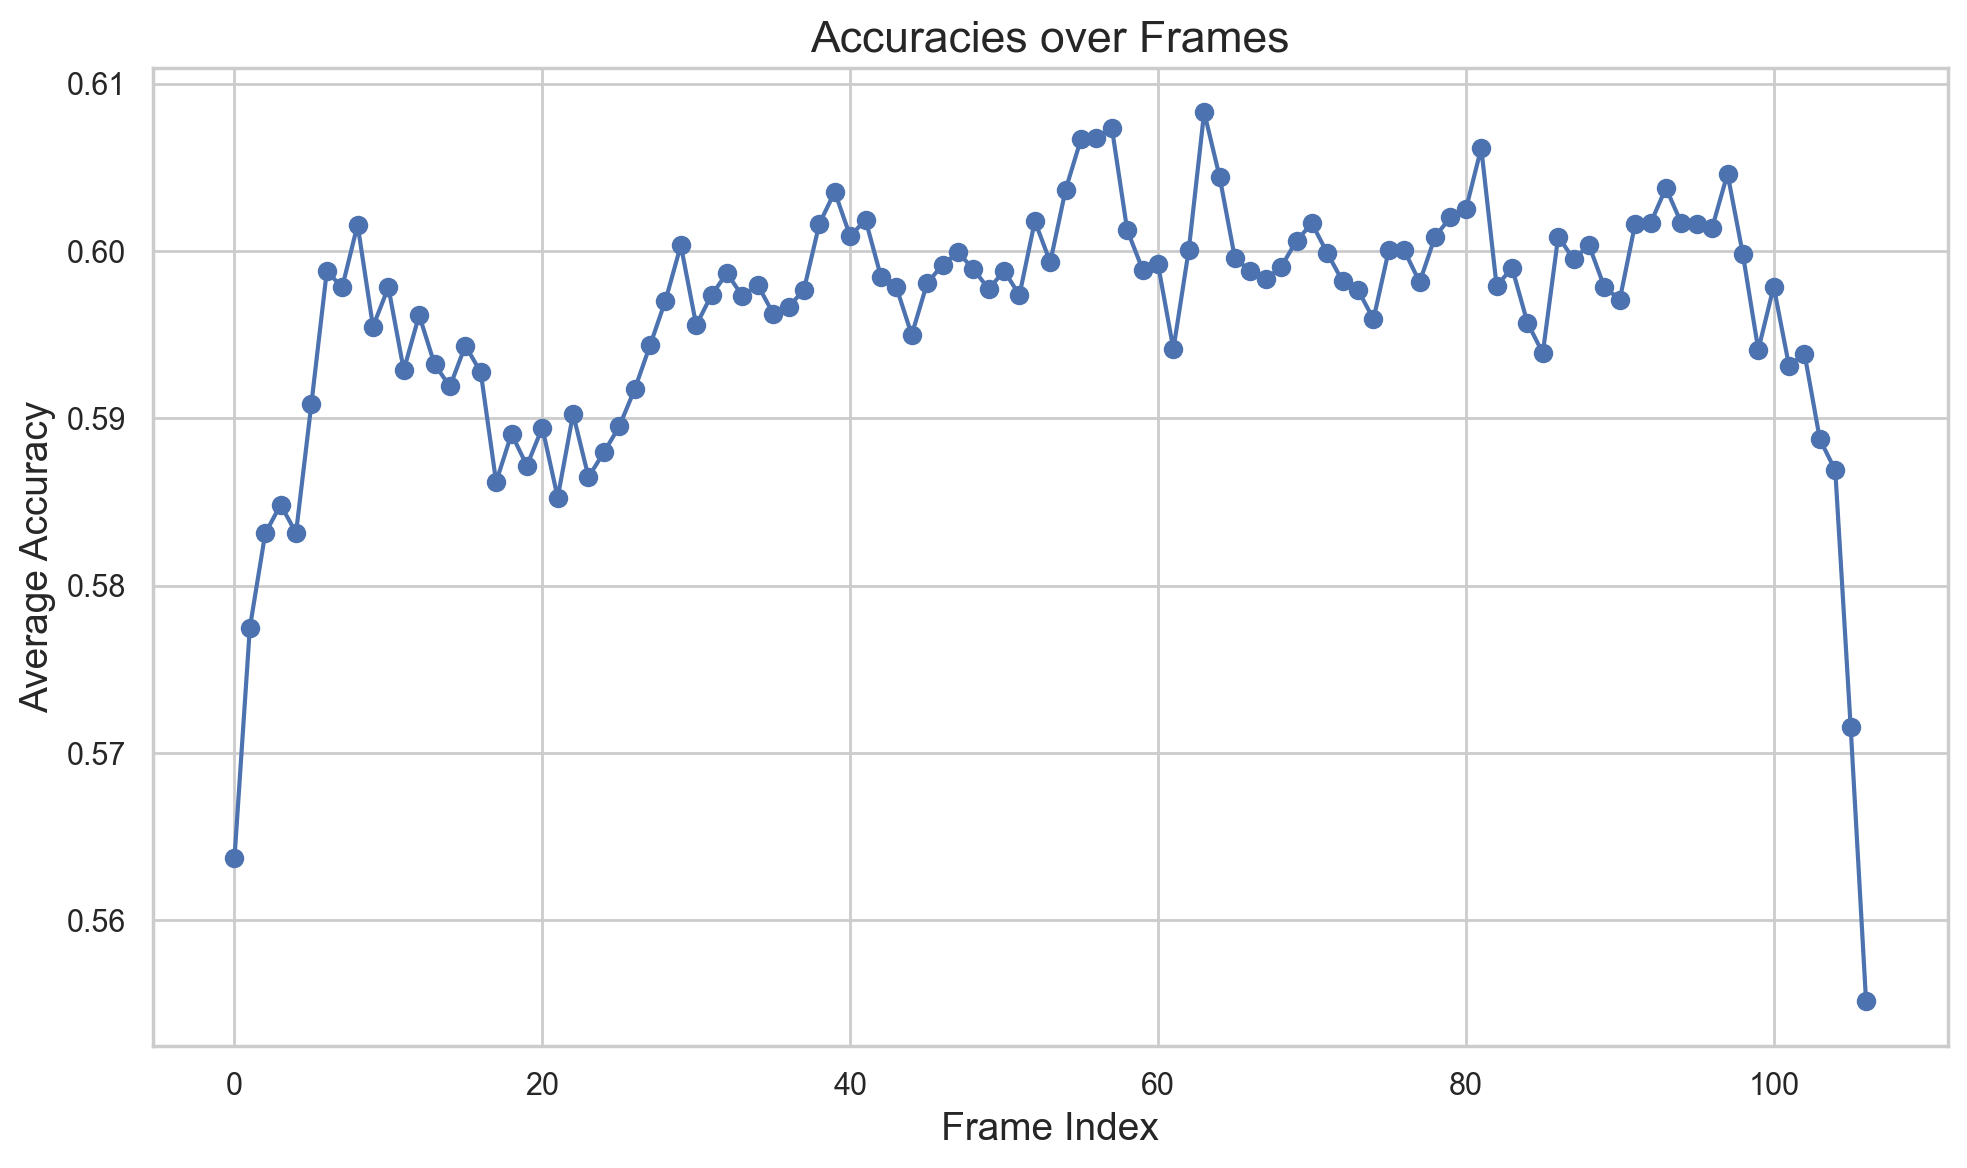

In [ ]:
# Compute average accuracy per frame
frame_accuracies = frame_correct_counts / frame_total_counts

# Plot the results
import matplotlib.pyplot as plt

frames = torch.arange(num_frames)
plt.figure(figsize=(10, 6))
plt.plot(frames, frame_accuracies, marker='o')
plt.title("Accuracies over Frames", fontsize=16)
plt.xlabel("Frame Index", fontsize=14)
plt.ylabel("Average Accuracy", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig('./thesis/figures/accuracy_over_frames.png', dpi=100, bbox_inches='tight')
plt.show()